In [1]:
import glob
import os

import pandas as pd

In [2]:
# Ground Truth CSV
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)
print("Número de Ground Truths: ", len(gt_df))

Número de Ground Truths:  188


### Functions to group predictions and ground truth annotations (if same specie and overlapping times)

In [3]:
def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)
    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)
    
    return combined_annotations

In [4]:
# gt_df = group_consecutive_annotations_gt(gt_df)
# gt_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame
# print("Número de Ground Truths agrupados: ", len(gt_df))

### Auxiliar Functions

In [5]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

In [79]:
def is_detection_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if iou >= iou_threshold:
                return True
    return False

def is_detection_classification_birdnet(gt_row, predictions_df, confidence_threshold=0, iou_threshold=0):
    for _, prediction in predictions_df.iterrows():
        if float(prediction['Confidence']) >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if (prediction['Scientific name'].lower() == gt_row['specie'].lower() and
                iou >= iou_threshold):
                return True, prediction
    return False, None

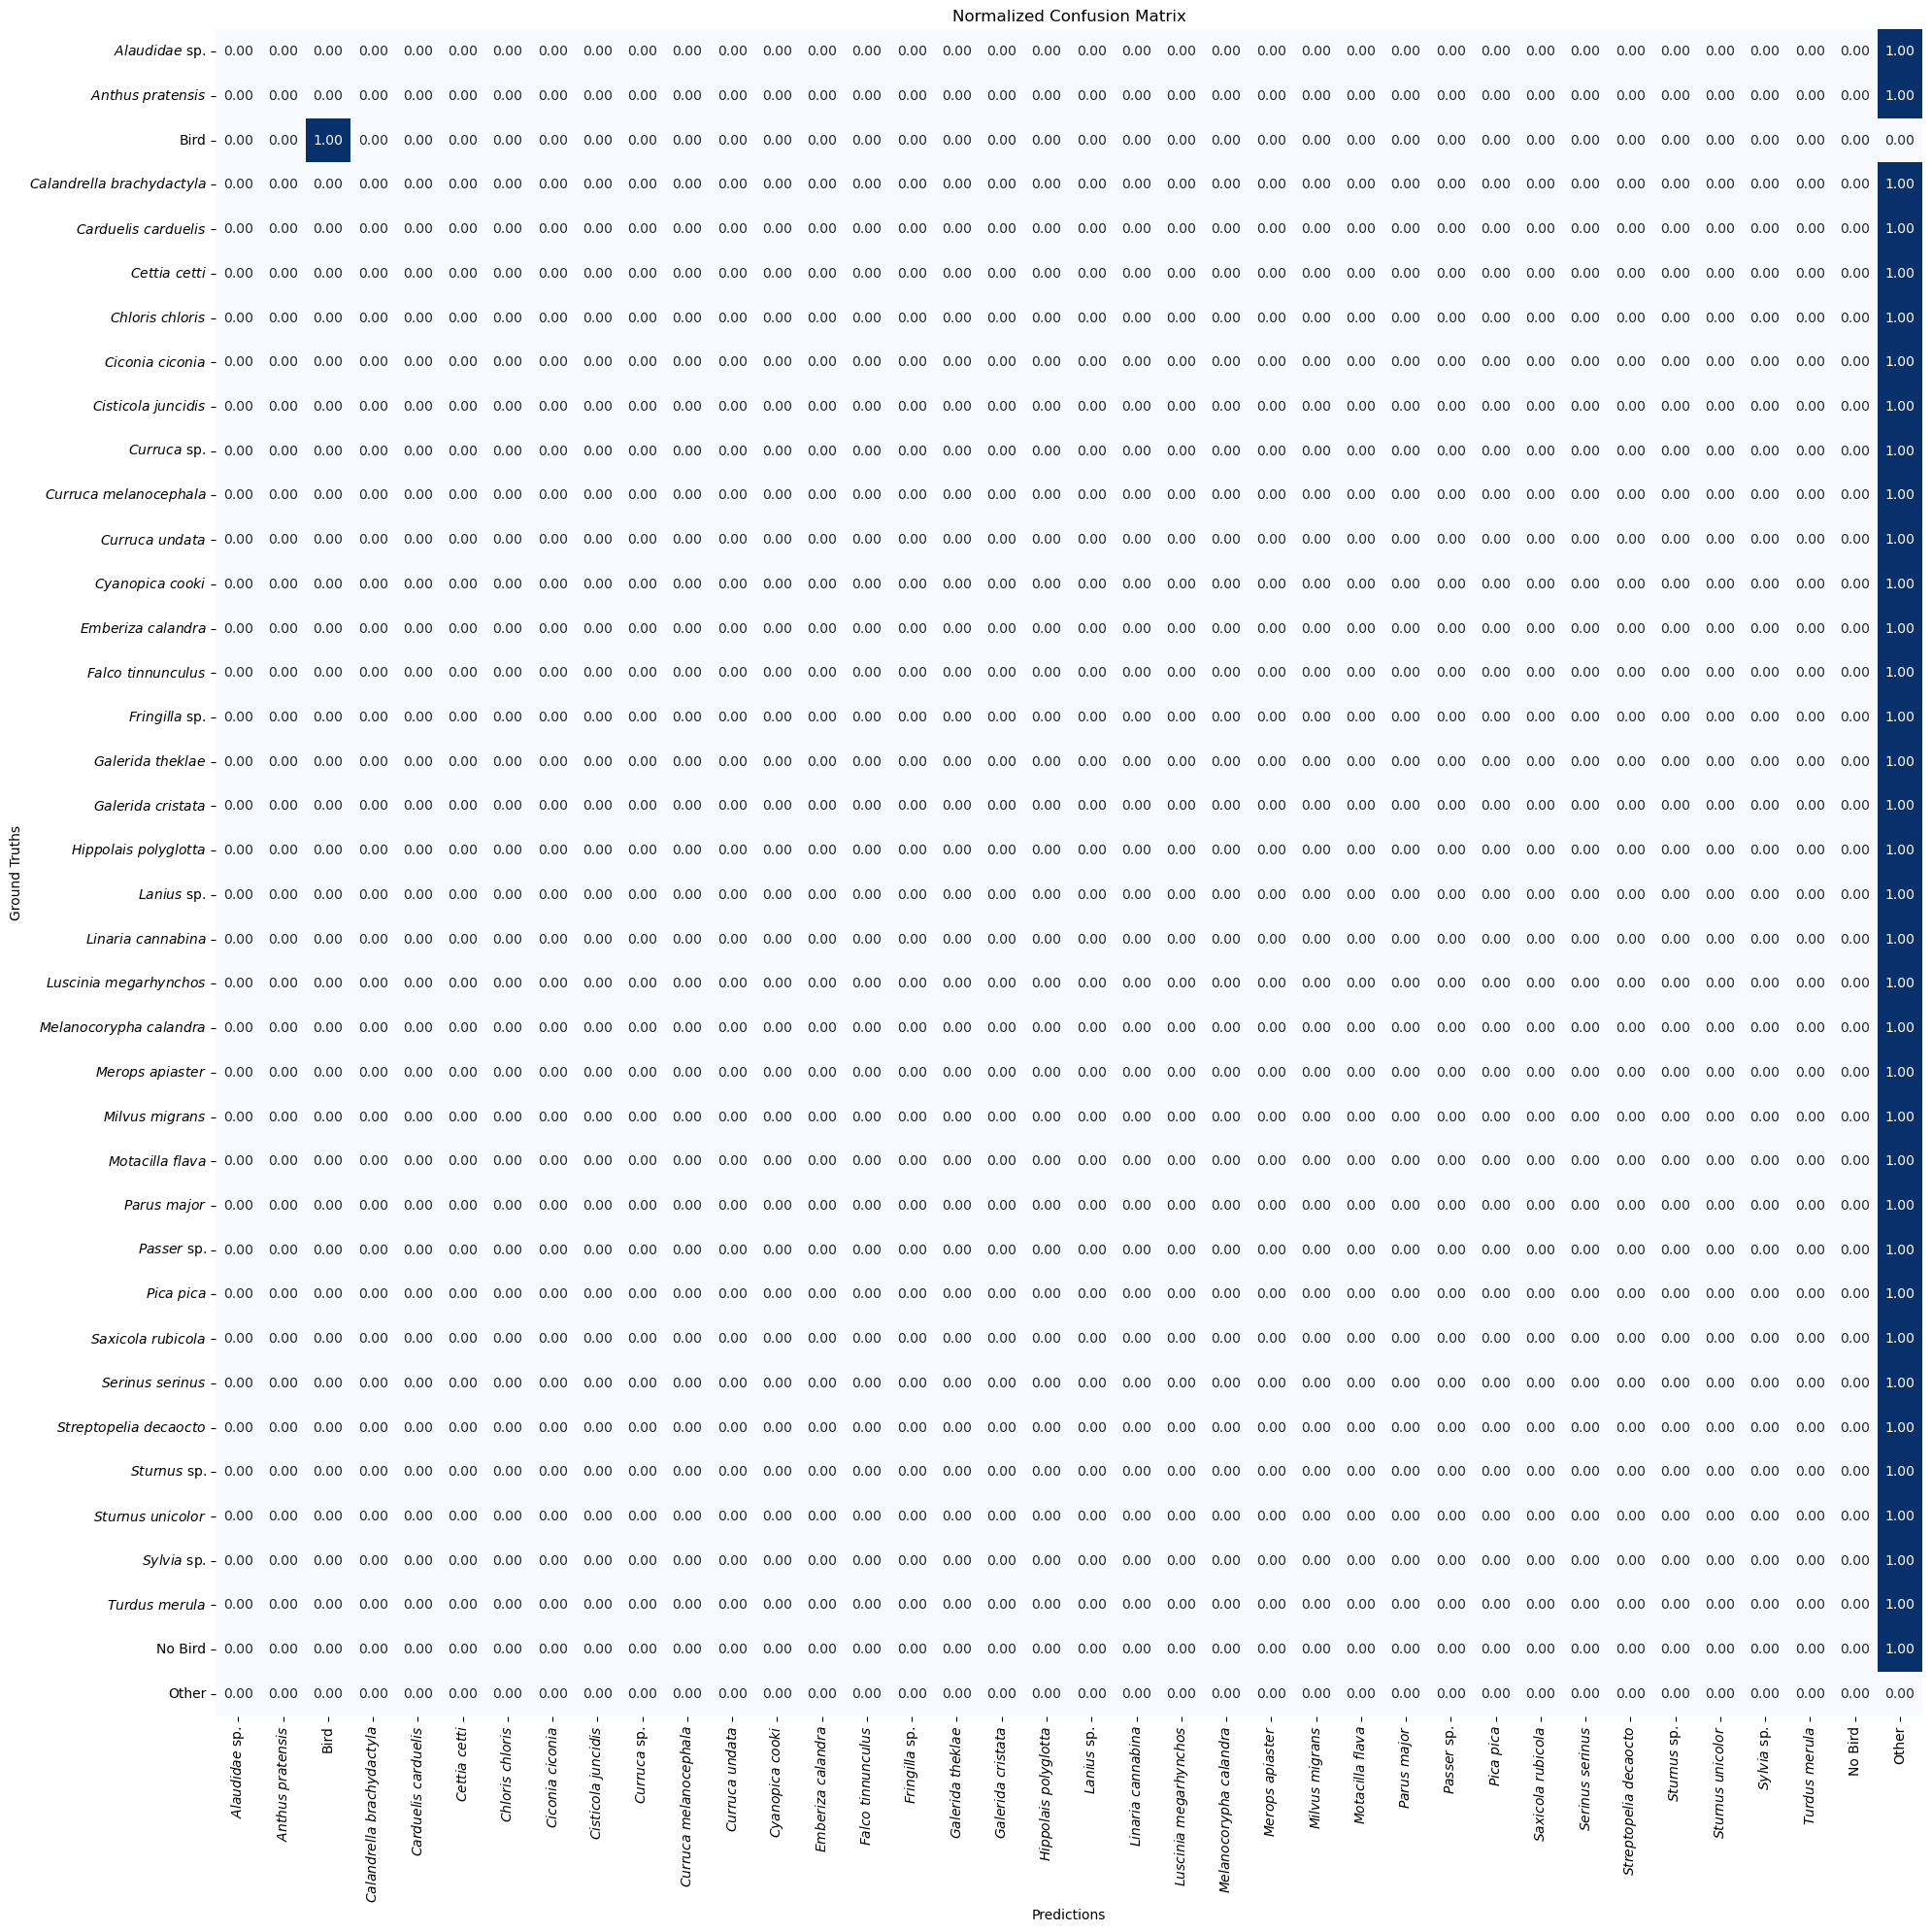

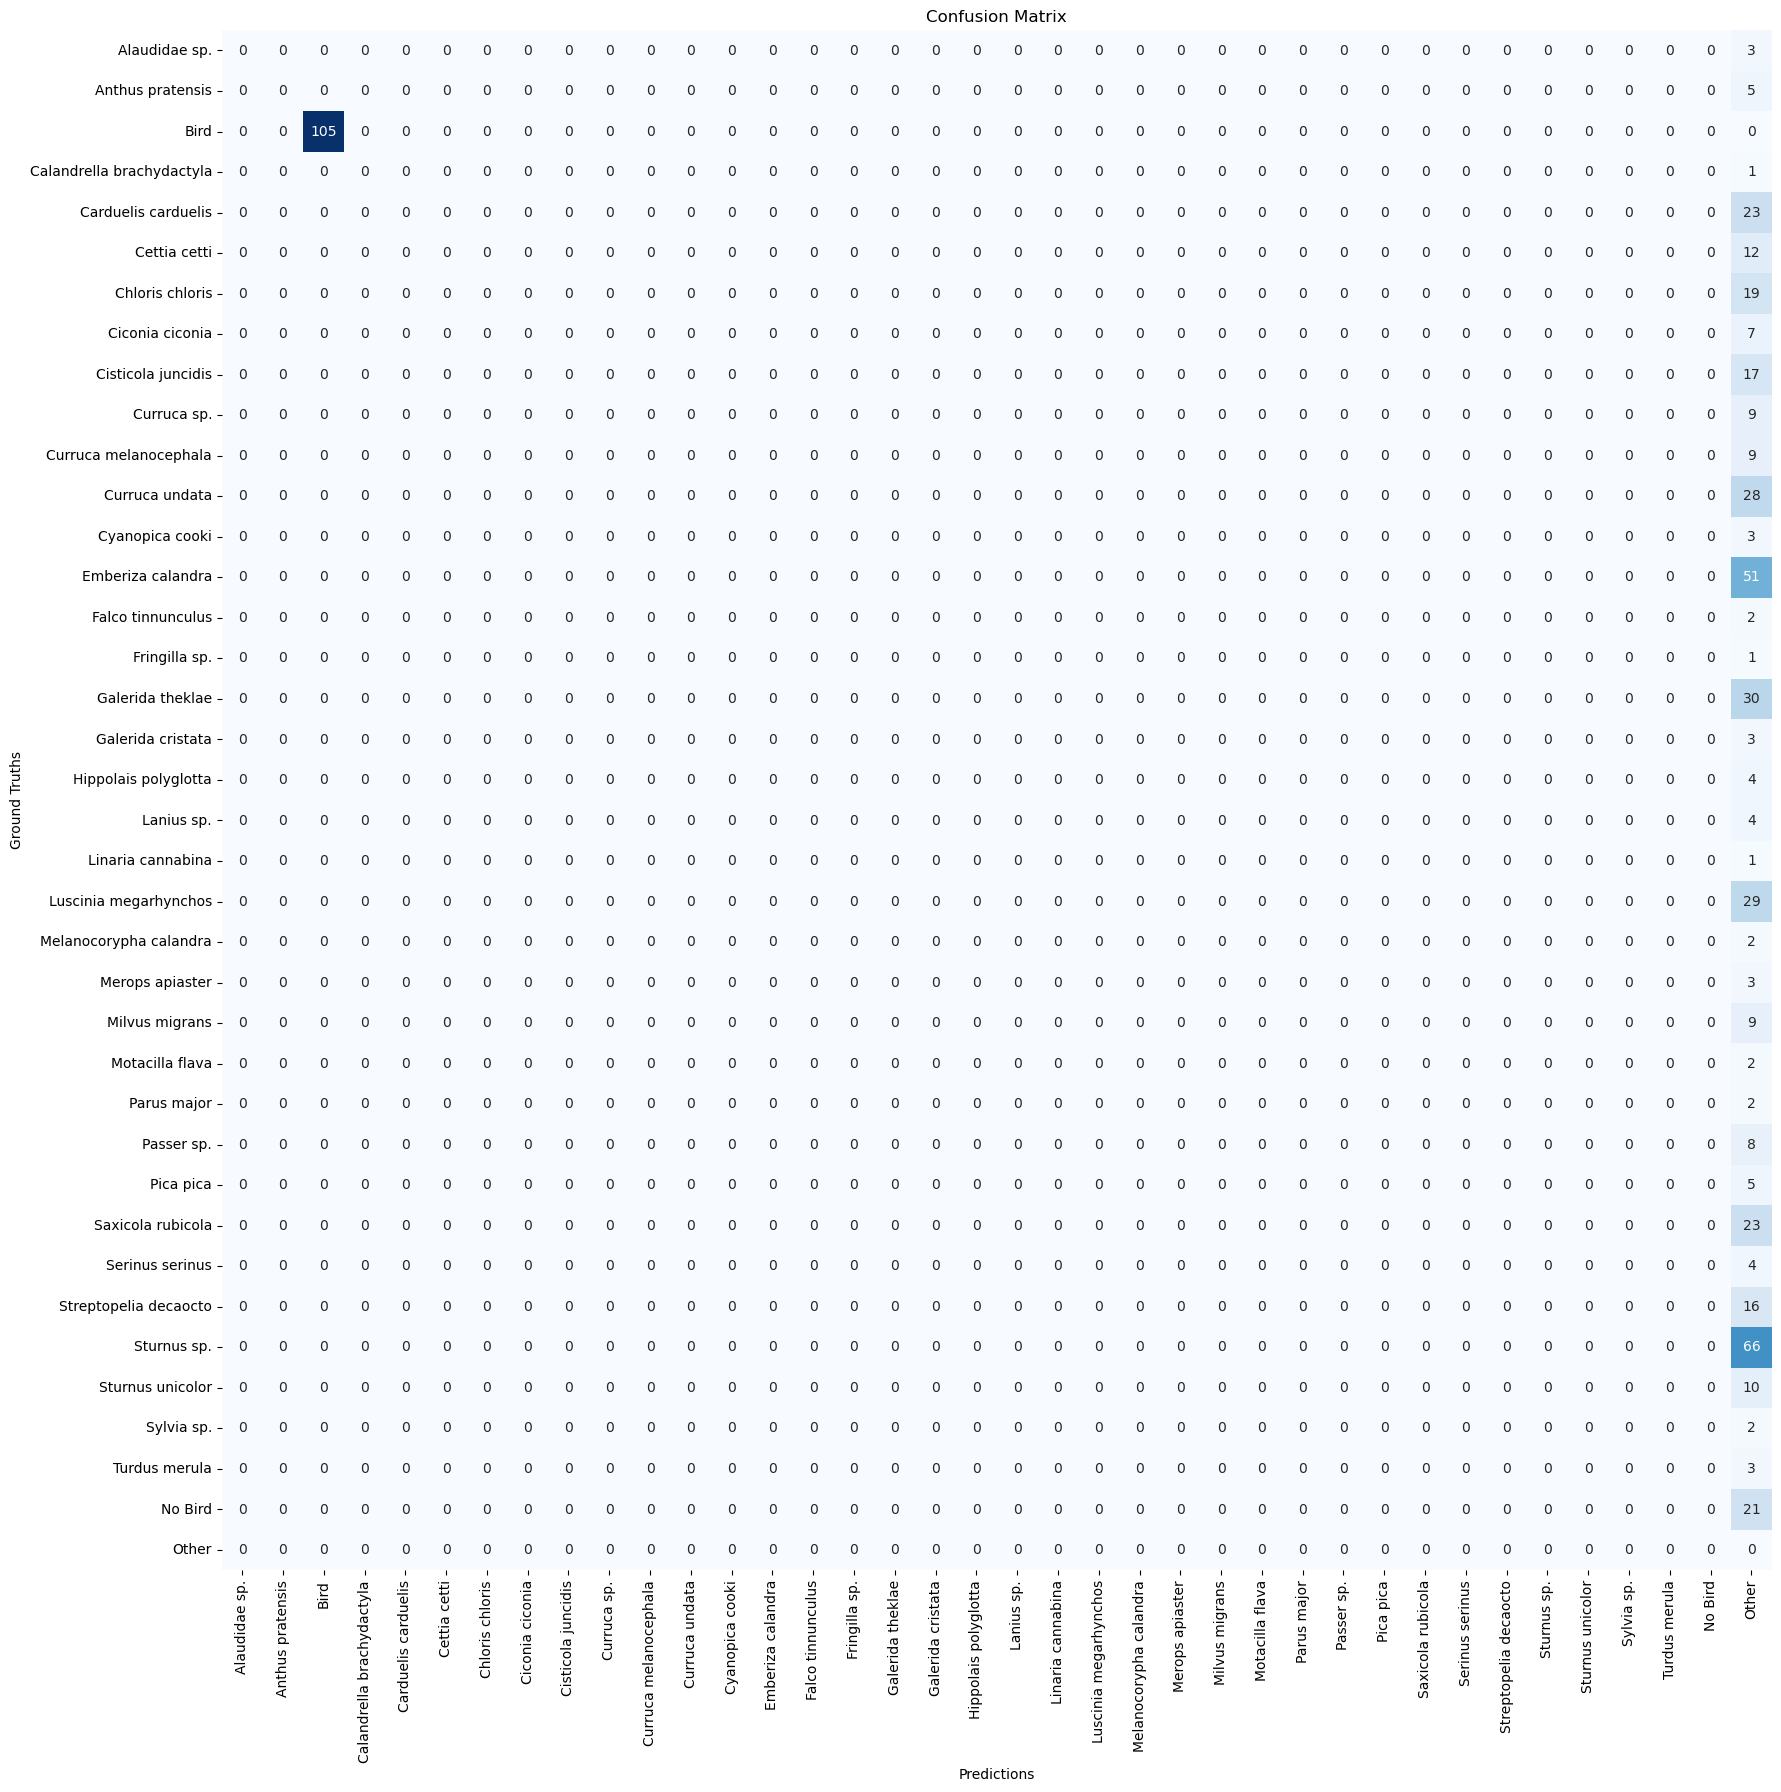

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define transformation function
def transform_species_name(specie):
    if specie == "Bird":
        return specie
    elif specie == "No audio":
        return "No Bird"
    elif specie == "Other":
        return "Other"
    elif specie == "Galerida Cristata":
        return "Galerida cristata"
    elif specie == "Linaria Cannabina":
        return "Linaria cannabina"
    elif len(specie.split()) == 2:
        return specie  # Handle italic in the plot
    else:
        return f"{specie} sp."  # Handle italic in the plot

# Load data
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/test_with_bg.csv"
gt_df = pd.read_csv(gt_csv)

# Define unique species and initialize confusion matrix
unique_species = gt_df['specie'].unique().tolist() + ['Other']
conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

# Process each prediction file
for _, gt_row in gt_df.iterrows():
    if len(gt_row['path'].split('.')[-1]) == 1:
        gt_row['path'] = gt_row['path'] + '0'
    pred_file_path = f"../BirdNET/Predictions/4_BaseClassifier/{gt_row['path']}.BirdNET.results.csv"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'Other'
            else:
                predicted_species = 'Other'
        else:
            predicted_species = 'Other'
    else:
        predicted_species = 'Other'
    
    true_species = gt_row['specie']
    if true_species == "Bird":
        predicted_species = true_species
    conf_matrix.at[true_species, predicted_species] += 1

# Normalize by row
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

# Apply transformation to confusion matrix labels
transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

# Create the plot
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')

# Customize labels for italic formatting
ax = plt.gca()
xticklabels = []
yticklabels = []
for label in ax.get_xticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    xticklabels.append(text)
ax.set_xticklabels(xticklabels, rotation=90)

for label in ax.get_yticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    yticklabels.append(text)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()

# save as png in the max resolution
#plt.savefig('confusion_matrix_species.png', dpi=300, bbox_inches='tight')

plt.show()

# Non normalized confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')
plt.show()


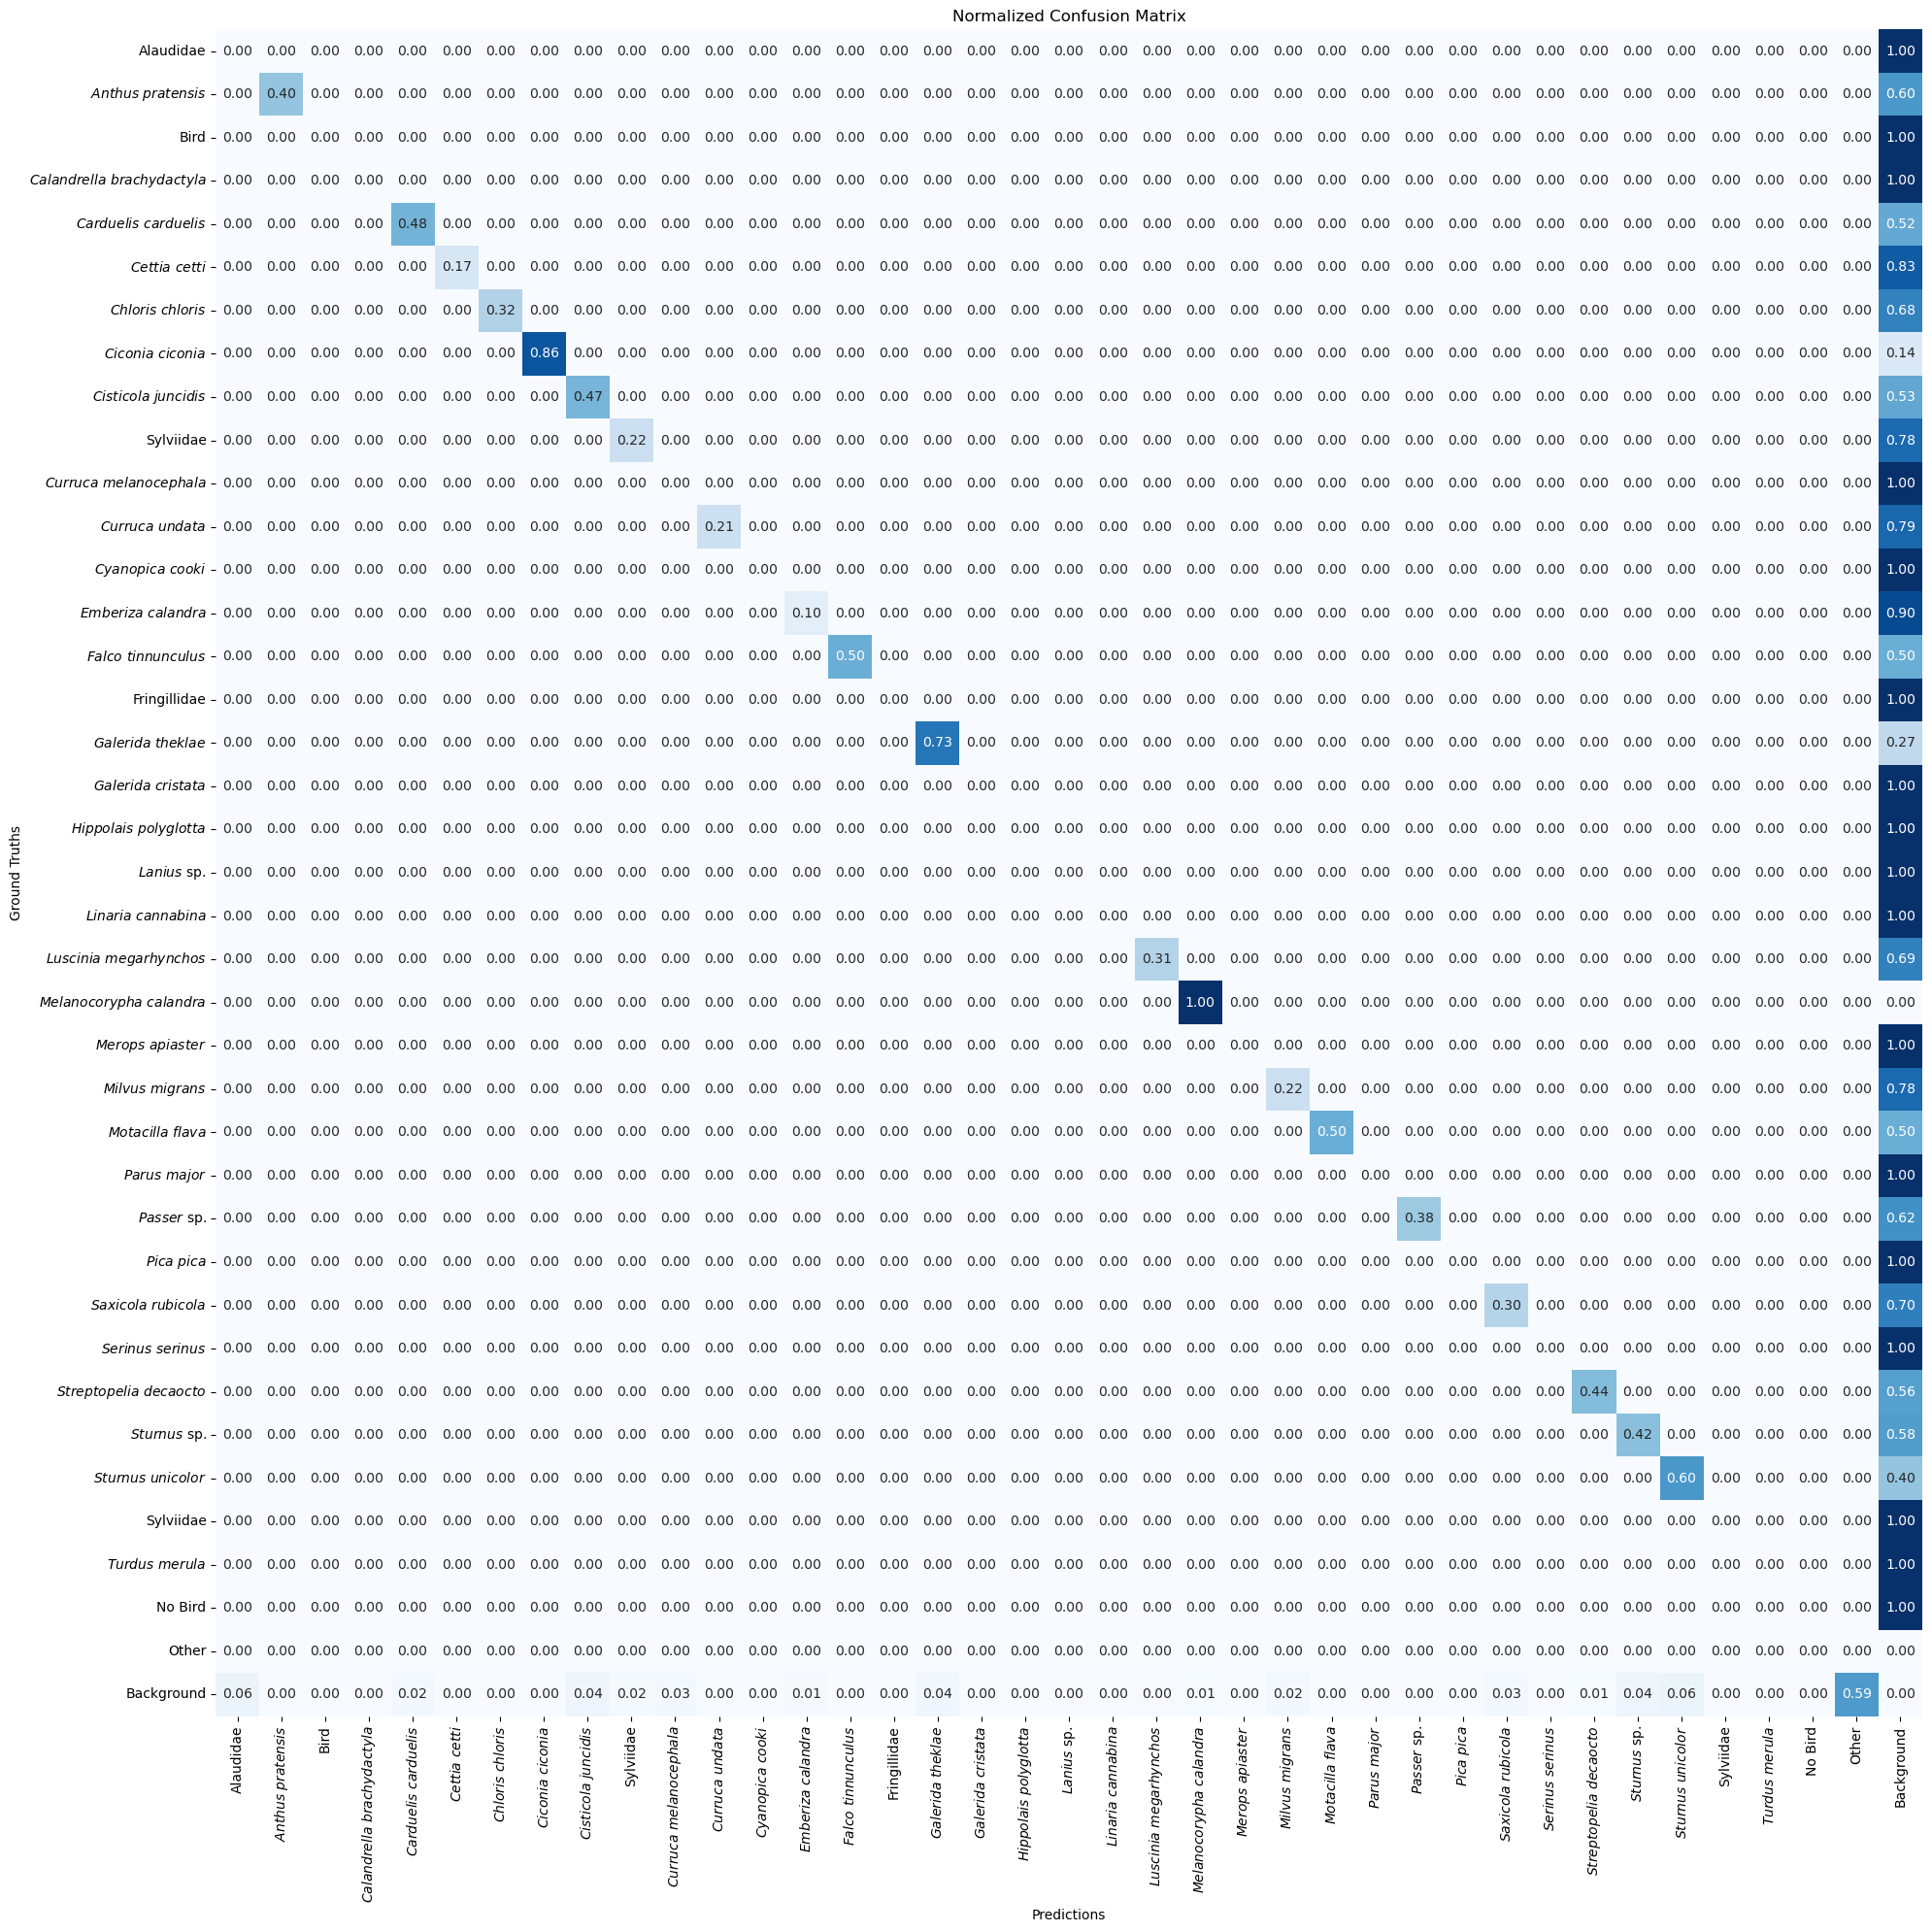

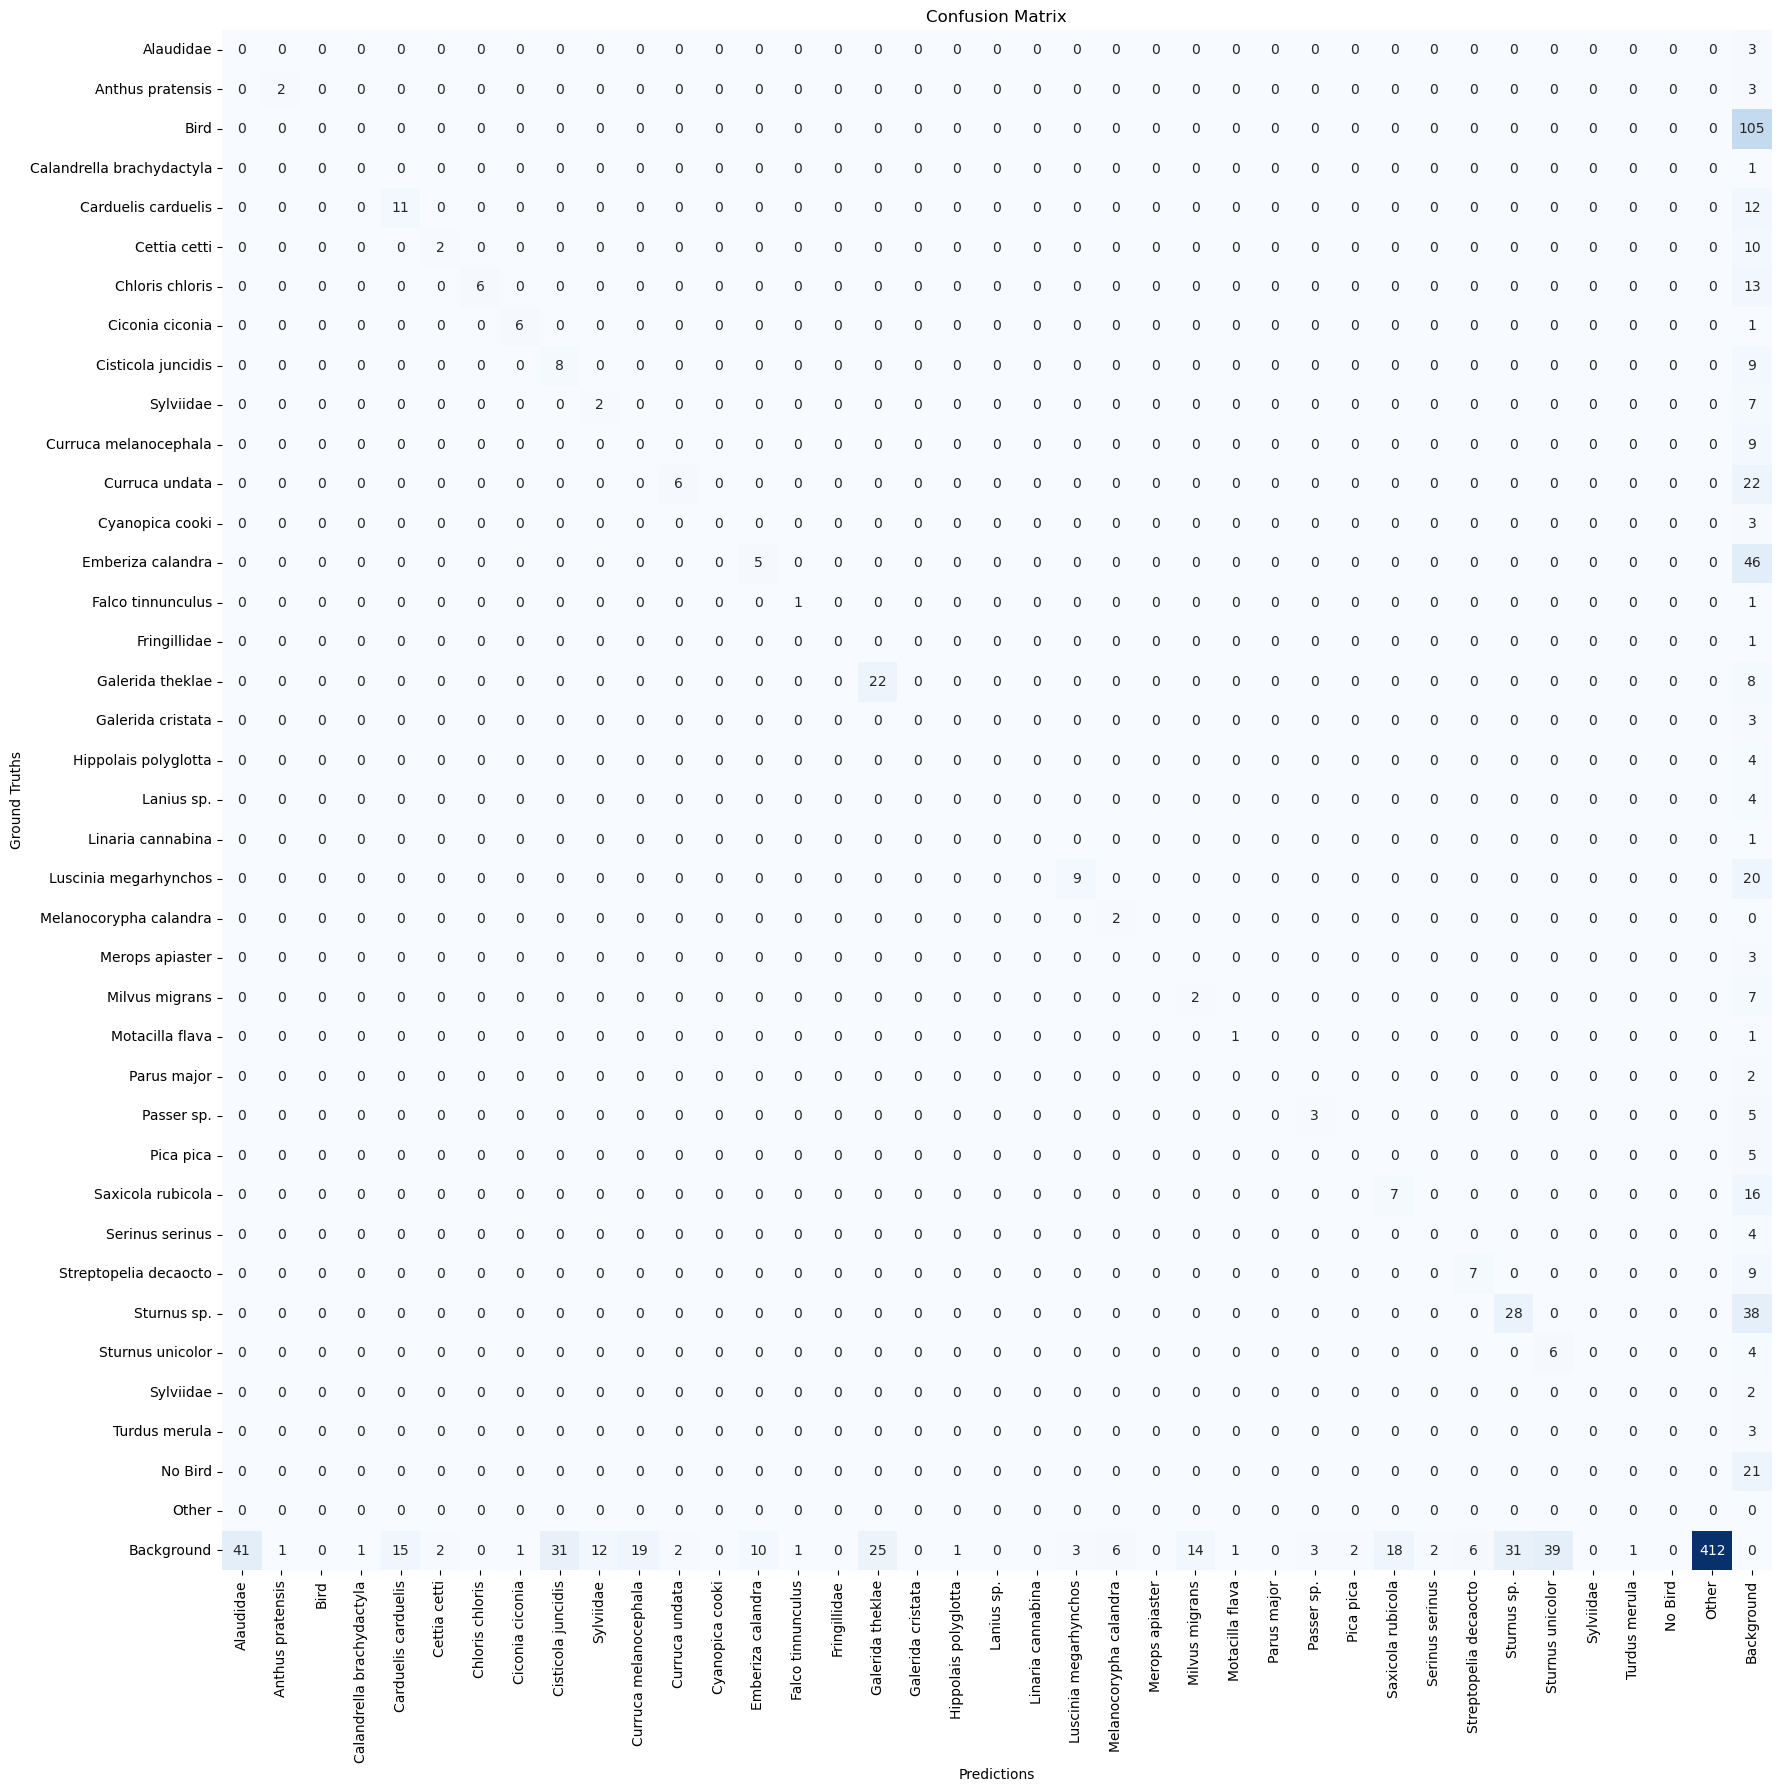

BirdNET
Número de Anotaciones:  521
Number of predictions: 836
True Positive:  136
False Positive:  700
False Negative:  406
True Negative:  0
Accuracy:  0.10950080515297907
Precision:  0.16267942583732056
Recall:  0.25092250922509224
F1 Score:  0.19738751814223512
Idx Pred/Ann:  1.6046065259117082


In [83]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Función para transformar los nombres de las especies
def transform_species_name(specie):
    if specie == "Bird":
        return specie
    elif specie == "No audio":
        return "No Bird"
    # Si Galerida cristata, se transforma a Galerida Cristata
    elif specie == "Galerida Cristata":
        return "Galerida cristata"
    # Si Linnaria cannabina, se transforma a Linaria Cannabina
    elif specie == "Linaria Cannabina":
        return "Linaria cannabina"
    elif specie == "Sylvia" or specie == "Curruca" or specie == "Sylviidae":
        return "Sylviidae"
    elif specie == "Background":
        return "Background"
    elif specie == "Other":
        return "Other"
    elif specie == "Fringilla":
        return "Fringillidae"
    elif specie == "Alaudidae":
        return "Alaudidae"
    elif len(specie.split()) == 2:
        return specie  # Se manejará la cursiva en el gráfico
    else:
        return f"{specie} sp."  # Se manejará la cursiva en el gráfico

# Load data
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/test_with_bg.csv"
gt_df = pd.read_csv(gt_csv)

iou_threshold = 0

number_of_annotations = 521

# Initialize counters
TP = 0
FP = 0
FN = 0
TN = 0

# Define unique species and initialize confusion matrix
unique_species = gt_df['specie'].unique().tolist() + ['Other'] + ['Background']
conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

number_of_predictions = 0

# Extract basename of the file and add as basename column
gt_df['basename'] = gt_df['path'].apply(lambda x: os.path.basename(x).split('.')[0].split('/')[-1])

# Read all the predictions and group them, put all them in the same dataframe
pred_file_path = "../BirdNET/Predictions/8_CustomClassifier_Append/"
predictions = pd.DataFrame()

# Read all CSV files in the folder
all_files = glob.iglob(os.path.join(pred_file_path, '**/*.csv'), recursive=True)
for file in all_files:
    # Read file and if there are predictions, group them
    predictions_df = pd.read_csv(file)
    if len(predictions_df) > 0:
        grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
        if grouped_predictions:
            # Add the basename of the file as a new column
            for group in grouped_predictions:
                group['basename'] = os.path.basename(file).split('.')[0]
            predictions = pd.concat([predictions, pd.DataFrame(grouped_predictions)], ignore_index=True)

predictions = predictions.loc[predictions.groupby(['basename','Start (s)', 'End (s)'])['Confidence'].idxmax()]

number_of_predictions = len(predictions)

# Inicializamos las métricas
TP, FP, FN, TN = 0, 0, 0, 0

# Agrupamos predicciones por basename para que coincidan con los ficheros en gt_df
grouped_predictions = predictions.groupby('basename')

# Procesamos cada archivo de predicciones
for basename, predictions_df in grouped_predictions:
    # Obtenemos las anotaciones de gt_df para el basename actual
    gt_rows = gt_df[gt_df['basename'] == basename]

    # Procesamos cada anotación
    for _, gt_row in gt_rows.iterrows():
        # Comprobamos si hay detección
        detclass, pred = is_detection_classification_birdnet(gt_row, predictions_df, confidence_threshold=0, iou_threshold=iou_threshold)
        if detclass:
            predicted_species = pred['Scientific name']
            # Add to the confusion matrix
            conf_matrix.at[gt_row['specie'], predicted_species] += 1
            TP += 1
            # Remove the pred from the predictions dataframe so it is not used again by Start, End and Scientific name
            predictions_df = predictions_df.drop(pred.name)
        else:
            # Add to the confusion matrix
            conf_matrix.at[gt_row['specie'], 'Background'] += 1
            FN += 1
    
    # Procesamos las predicciones restantes
    for _, pred in predictions_df.iterrows():
        # If pred Scientific name not in unique species, set to 'Other'
        if pred['Scientific name'] not in unique_species:
            pred['Scientific name'] = 'Other'
        conf_matrix.at['Background', pred['Scientific name']] += 1
        FP += 1

# Normalize by row
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

# Apply transformation to confusion matrix labels
transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

# Create the plot
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')

# Customize labels for italic formatting
ax = plt.gca()
xticklabels = []
yticklabels = []
for label in ax.get_xticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    xticklabels.append(text)
ax.set_xticklabels(xticklabels, rotation=90)

for label in ax.get_yticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    yticklabels.append(text)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()

# save as pdf in the max resolution
plt.savefig('confusion_matrix_species_no_detector.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Non normalized confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')
plt.show()

print("BirdNET")
print("Número de Anotaciones: ", number_of_annotations)
print(f"Number of predictions: {number_of_predictions}")
print("True Positive: ", TP)
print("False Positive: ", FP)
print("False Negative: ", FN)
print("True Negative: ", TN)
    
print("Accuracy: ", TP/(TP + FP + FN))
print("Precision: ", TP/(TP + FP))
print("Recall: ", TP/(TP + FN))
print("F1 Score: ", 2 * TP / (2 * TP + FP + FN))

print("Idx Pred/Ann: ", number_of_predictions/number_of_annotations)

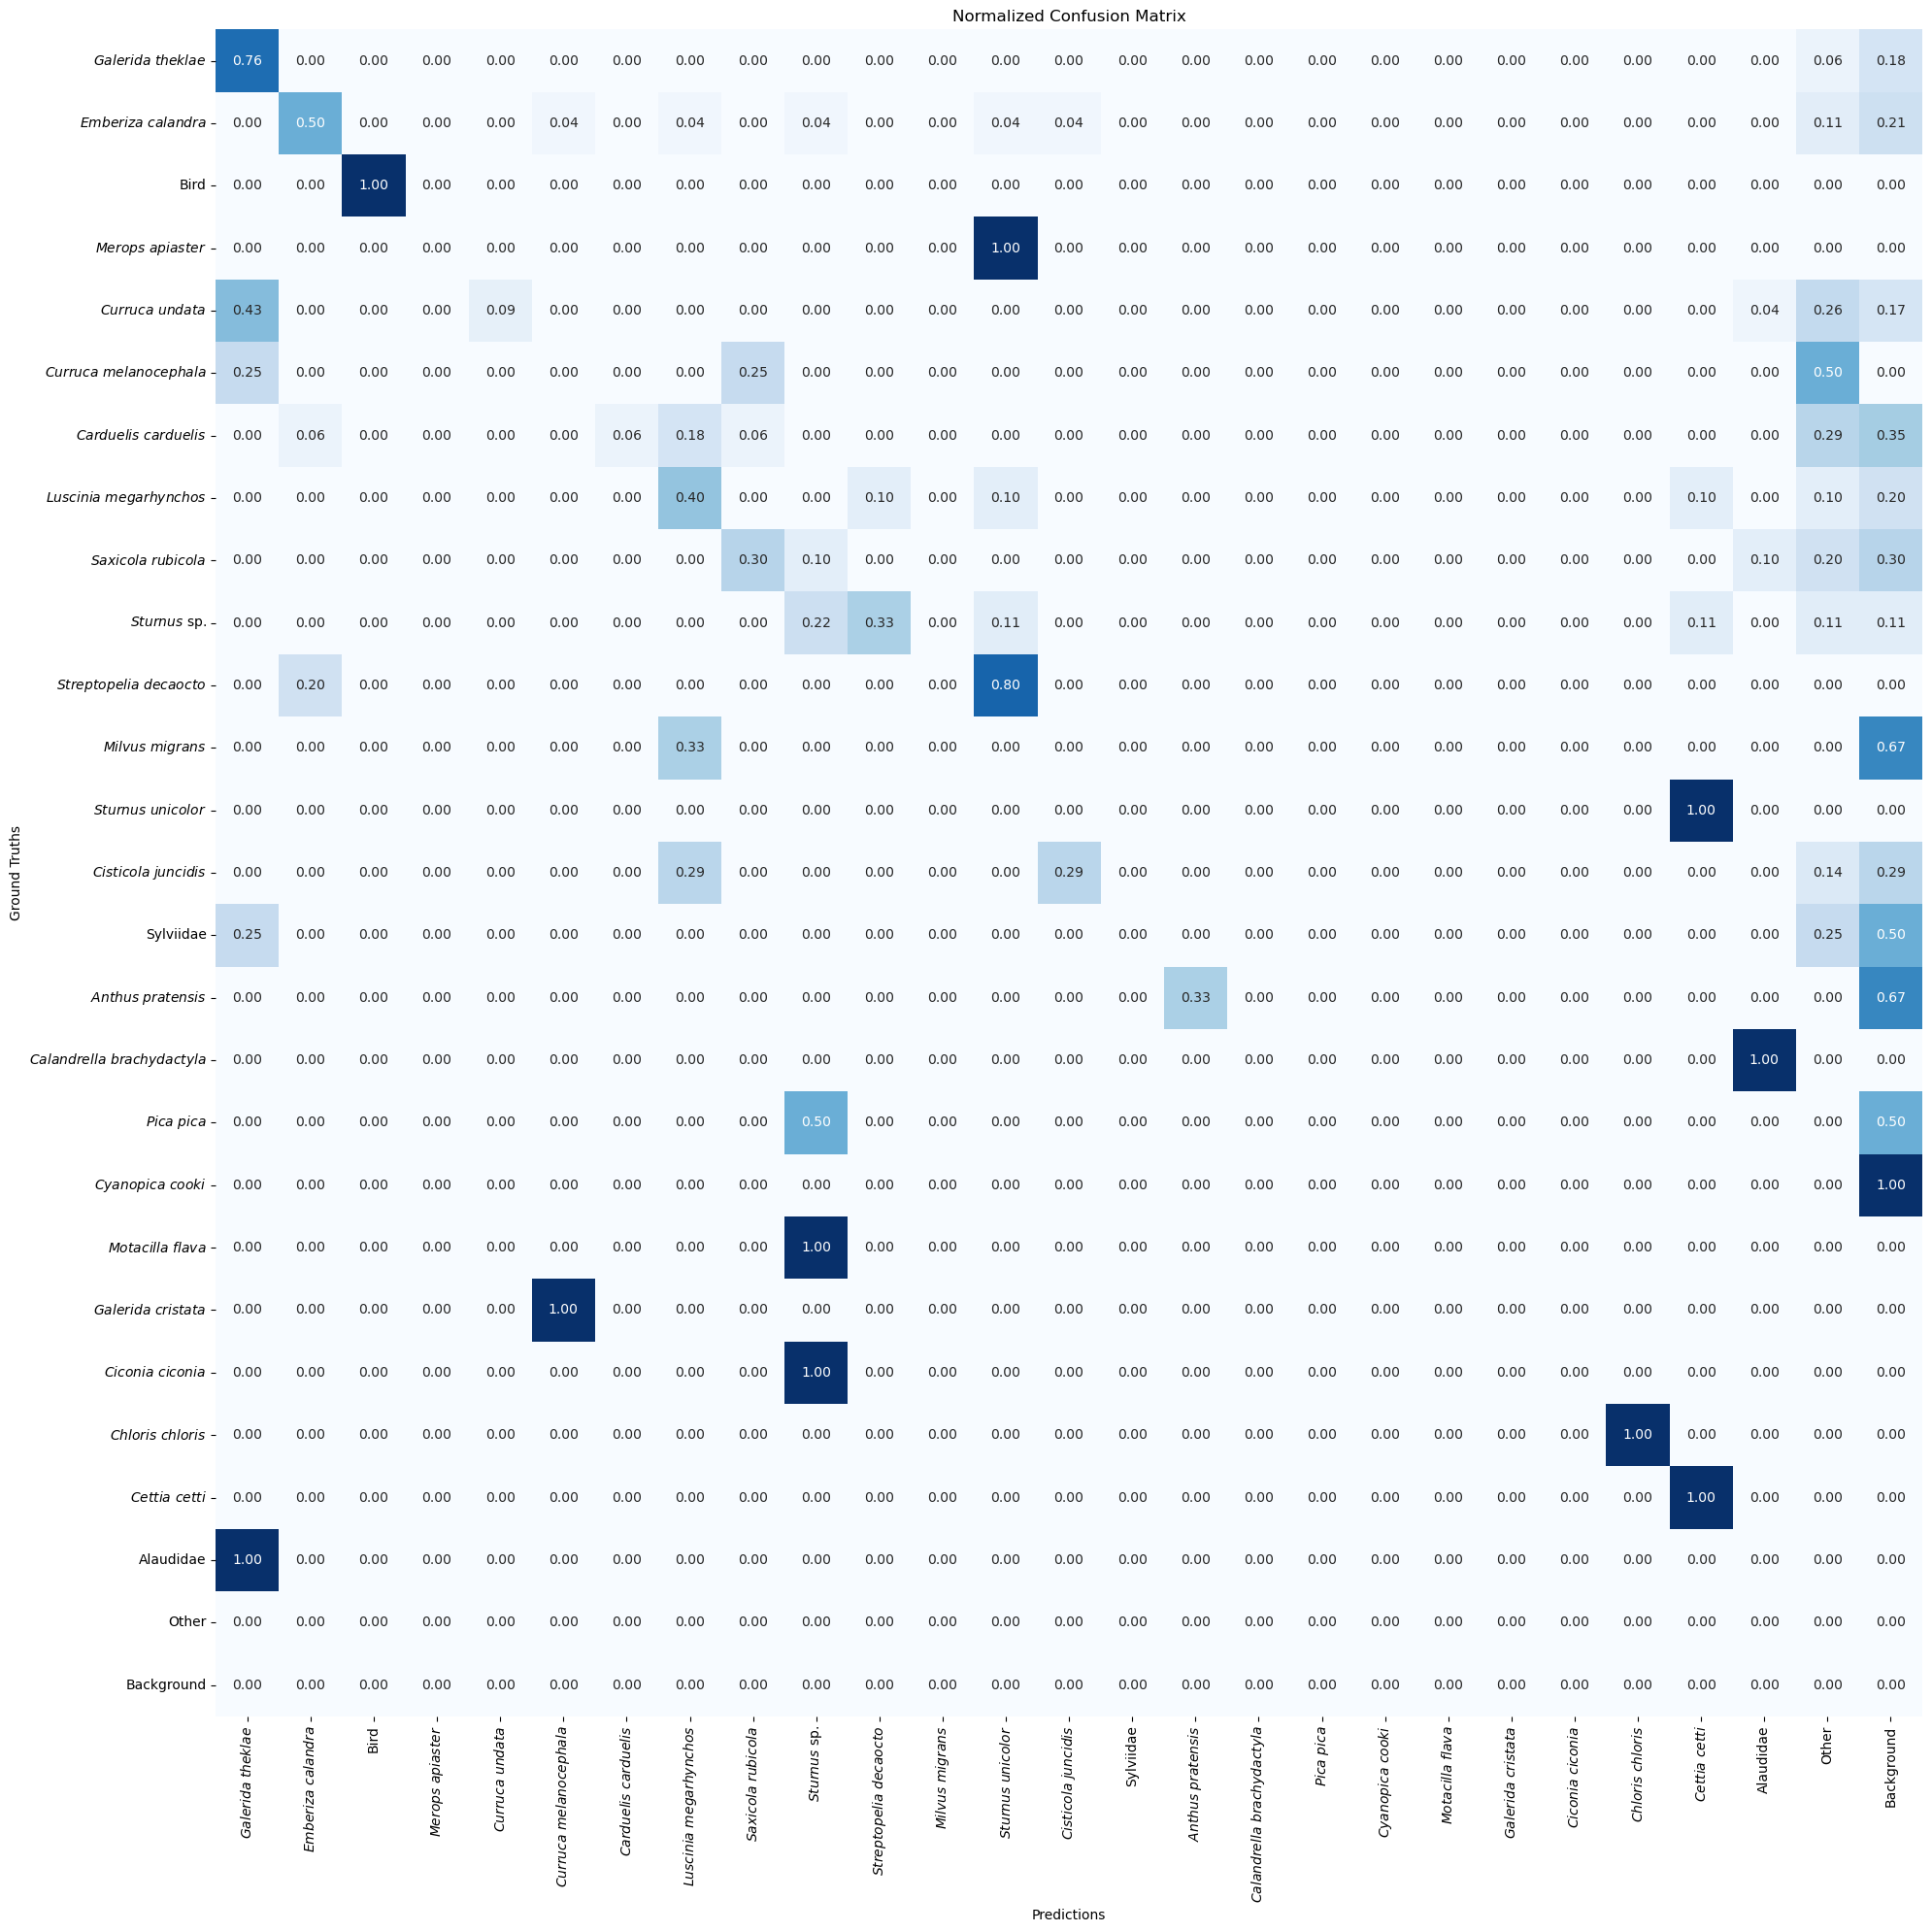

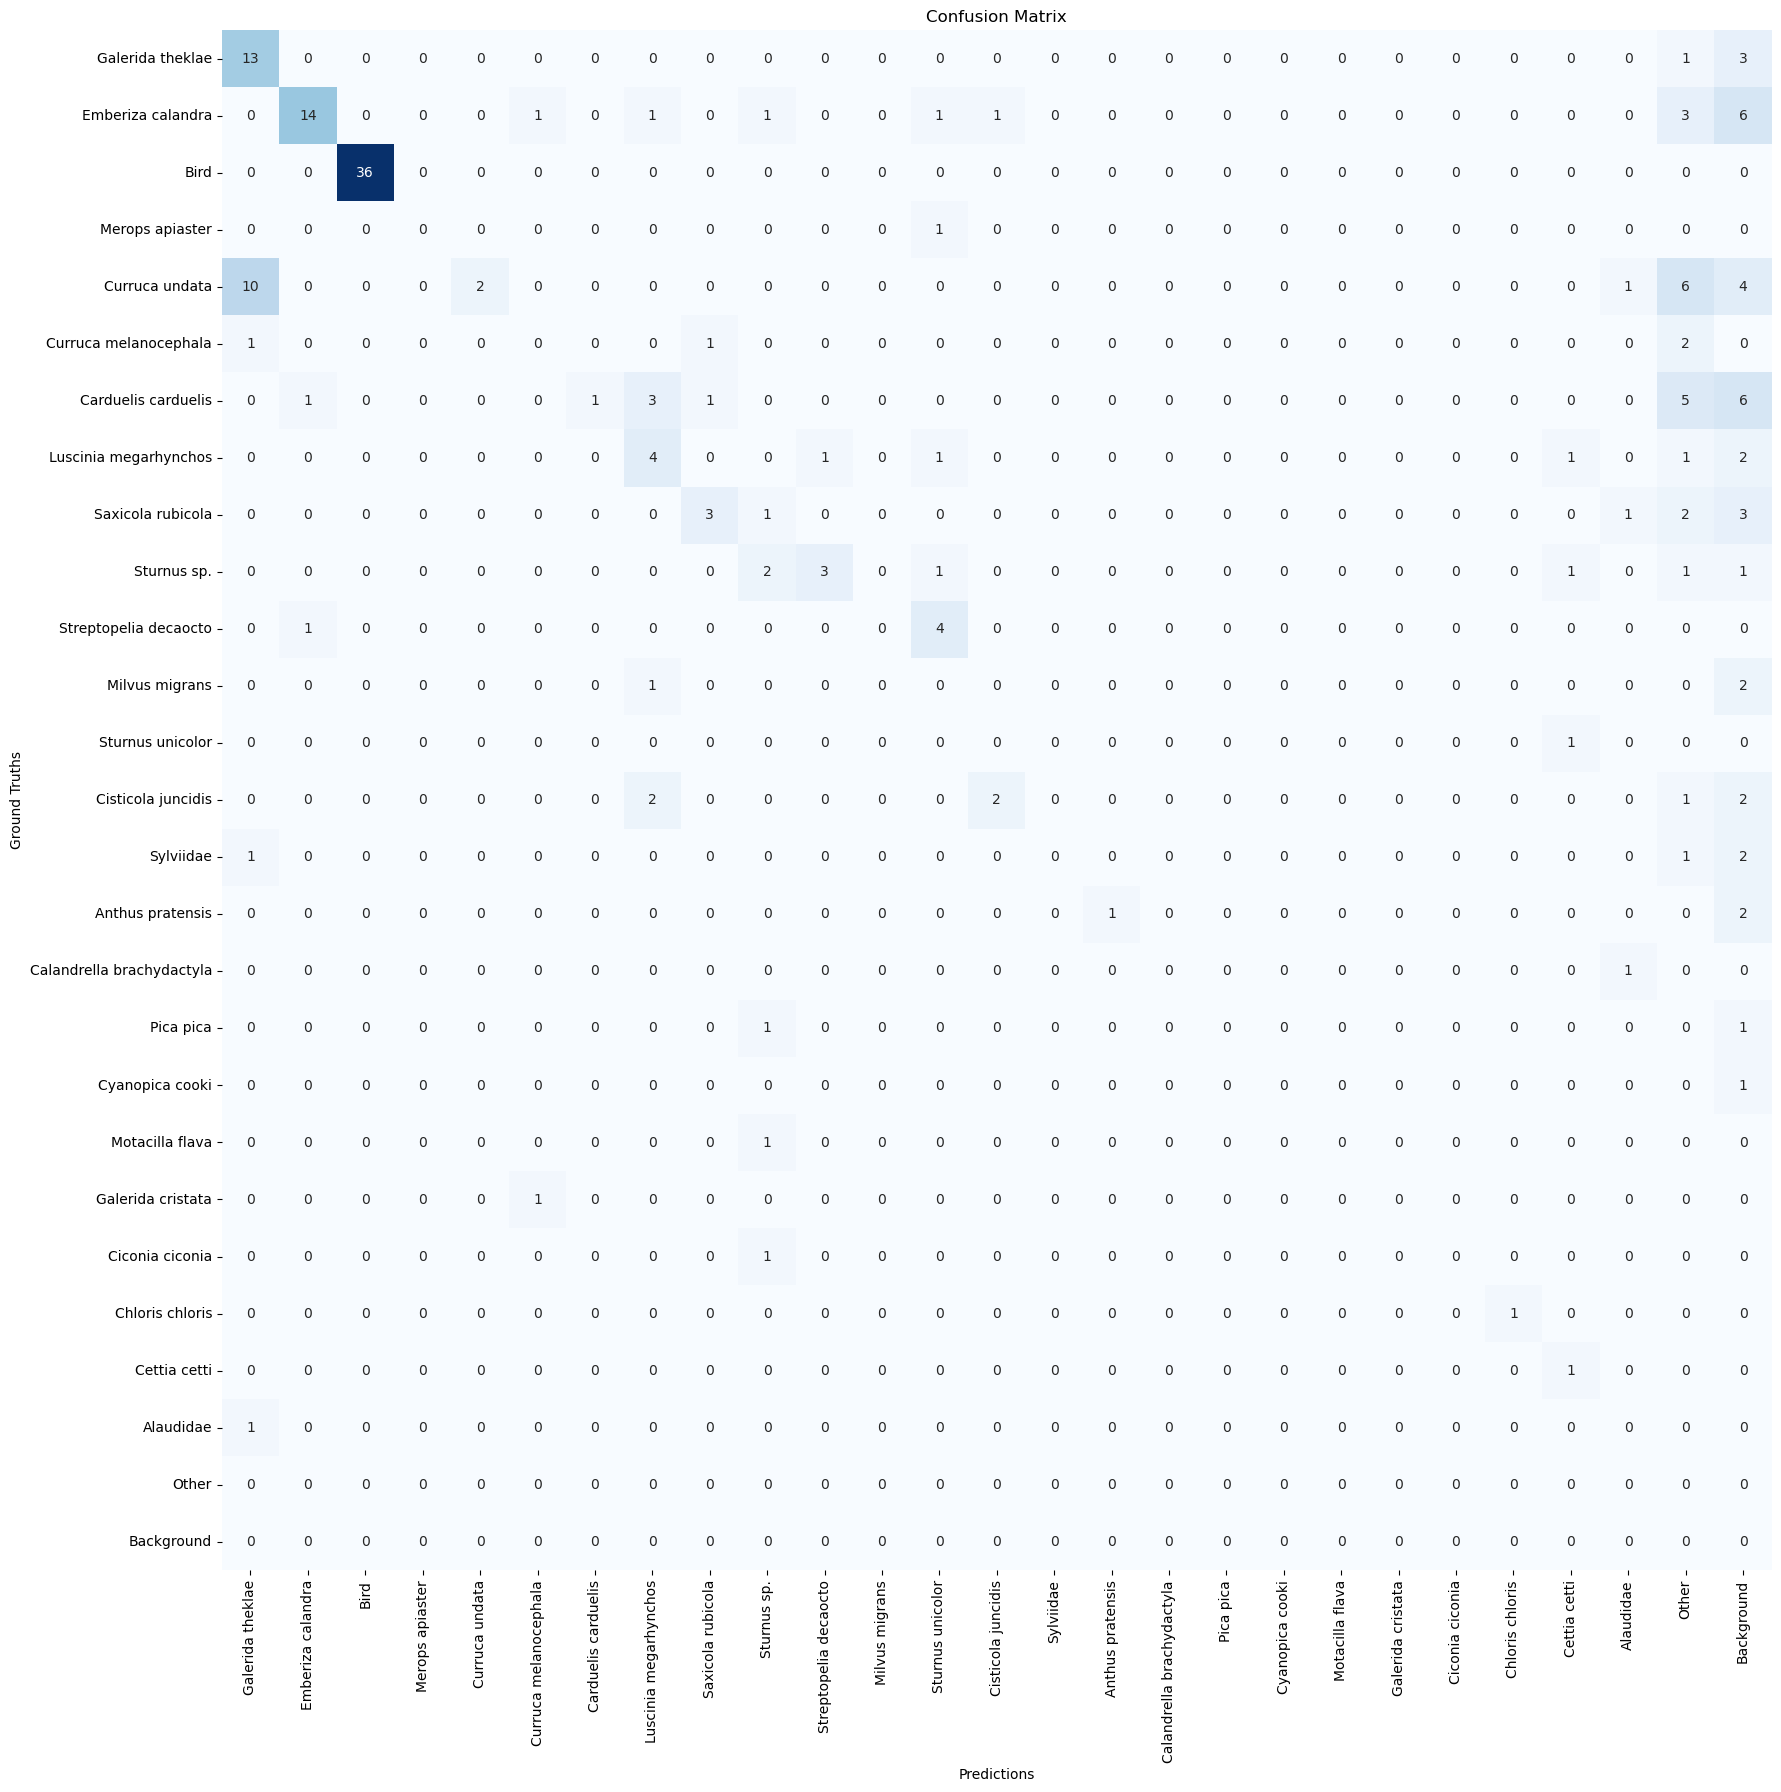

Accuracy:  0.425531914893617
Number of Predictions: 188
TP: 80
FP: 108
FN: 108
Accuracy: 0.425531914893617
Precision: 0.425531914893617
Recall: 0.425531914893617
F1 Score: 0.42553191489361697
Idx Pred/Ann: 1.0
Maximum Likelihood: 0.425531914893617


In [10]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Función para transformar los nombres de las especies
def transform_species_name(specie):
    if specie == "Bird":
        return specie
    elif specie == "No audio":
        return "No Bird"
    # Si Galerida cristata, se transforma a Galerida Cristata
    elif specie == "Galerida Cristata":
        return "Galerida cristata"
    # Si Linnaria cannabina, se transforma a Linaria Cannabina
    elif specie == "Linaria Cannabina":
        return "Linaria cannabina"
    elif specie == "Sylvia" or specie == "Curruca" or specie == "Sylviidae":
        return "Sylviidae"
    elif specie == "Background":
        return "Background"
    elif specie == "Other":
        return "Other"
    elif specie == "Alaudidae":
        return "Alaudidae"
    elif specie == "Fringilla":
        return "Fringillidae"
    elif len(specie.split()) == 2:
        return specie  # Se manejará la cursiva en el gráfico
    else:
        return f"{specie} sp."  # Se manejará la cursiva en el gráfico

# Load data
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"
gt_df = pd.read_csv(gt_csv)

# If class is curruca or sylvia set it as Sylviidae
gt_df.loc[gt_df['specie'] == 'Curruca', 'specie'] = 'Sylviidae'
gt_df.loc[gt_df['specie'] == 'Sylvia', 'specie'] = 'Sylviidae'

# Define unique species and initialize confusion matrix
unique_species = gt_df['specie'].unique().tolist() + ['Other'] + ['Background']


conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

# Process each prediction file
for _, gt_row in gt_df.iterrows():
    if len(gt_row['PRED_filename'].split('.')[-1]) == 1:
        gt_row['PRED_filename'] = gt_row['PRED_filename'] + '0'
    pred_file_path = f"../BirdNET/Predictions/predict_test_model12_conf015/{gt_row['PRED_filename']}.BirdNET.results.csv"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'Other'
        else:
            predicted_species = 'Background'

        if predicted_species == "Curruca" or predicted_species == "Sylvia":
            predicted_species = "Sylviidae"
    
    true_species = gt_row['specie']
    if true_species == "Bird" and predicted_species != "No prediction" and predicted_species != "No file" and predicted_species != "No group":
        predicted_species = true_species
    conf_matrix.at[true_species, predicted_species] += 1

# Normalize by row
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

# Apply transformation to confusion matrix labels
transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

# Create the plot
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')

# Customize labels for italic formatting
ax = plt.gca()
xticklabels = []
yticklabels = []
for label in ax.get_xticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    xticklabels.append(text)
ax.set_xticklabels(xticklabels, rotation=90)

for label in ax.get_yticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    yticklabels.append(text)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()

# save as pdf in the max resolution
plt.savefig('confusion_matrix_species.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Non normalized confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')
plt.show()

print("Accuracy: ", np.trace(conf_matrix) / np.sum(conf_matrix.to_numpy()))

# calculate average metrics 'Number of Predictions', 'TP', 'FP', 'FN', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann', 'Maximum Likelihood' and print
metrics = ['Number of Predictions', 'TP', 'FP', 'FN', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann', 'Maximum Likelihood']
metrics_values = {metric: 0 for metric in metrics}

for _, gt_row in gt_df.iterrows():
    if len(gt_row['PRED_filename'].split('.')[-1]) == 1:
        gt_row['PRED_filename'] = gt_row['PRED_filename'] + '0'
    pred_file_path = f"../BirdNET/Predictions/predict_test_model12_conf015/{gt_row['PRED_filename']}.BirdNET.results.csv"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'Other'
        else:
            predicted_species = 'Background'

        if predicted_species == "Curruca" or predicted_species == "Sylvia":
            predicted_species = "Sylviidae"
    
    true_species = gt_row['specie']
    if true_species == "Bird" and predicted_species != "No prediction" and predicted_species != "No file" and predicted_species != "No group":
        predicted_species = true_species

    if predicted_species == true_species:
        metrics_values['TP'] += 1
    else:
        metrics_values['FP'] += 1

    metrics_values['Number of Predictions'] += 1

metrics_values['FN'] = len(gt_df) - metrics_values['TP']
metrics_values['Accuracy'] = metrics_values['TP'] / metrics_values['Number of Predictions']
metrics_values['Precision'] = metrics_values['TP'] / (metrics_values['TP'] + metrics_values['FP'])
metrics_values['Recall'] = metrics_values['TP'] / (metrics_values['TP'] + metrics_values['FN'])
metrics_values['F1 Score'] = 2 * metrics_values['Precision'] * metrics_values['Recall'] / (metrics_values['Precision'] + metrics_values['Recall'])
metrics_values['Idx Pred/Ann'] = metrics_values['Number of Predictions'] / len(gt_df)
metrics_values['Maximum Likelihood'] = metrics_values['TP'] / len(gt_df)

for metric, value in metrics_values.items():
    print(f"{metric}: {value}")

Amblycorypha rotundifolia
Emberiza cia
Phoenicurus ochruros
Sitta neumayer
Tachycineta bicolor
Zonotrichia leucophrys
Spinus lawrencei
Anthus rubescens
Zonotrichia leucophrys
Zonotrichia leucophrys
Coccothraustes coccothraustes
Zonotrichia leucophrys
Poecile gambeli
Zonotrichia leucophrys
Zonotrichia leucophrys
Coturnicops noveboracensis
Auriparus flaviceps
Alauda arvensis
Sturnus vulgaris
Sturnus vulgaris
Sturnus vulgaris
Alauda arvensis
Hippolais polyglotta
Sturnus vulgaris
Chlidonias hybrida
Sturnus vulgaris
Sturnus vulgaris
Sturnus vulgaris
Sturnus vulgaris
Chordeiles minor
Progne chalybea
Chordeiles minor
Tetrax tetrax
Tetrax tetrax
Rhynchophanes mccownii
Alauda arvensis
Human non-vocal
Lophophanes cristatus
Sturnus vulgaris
Sturnus vulgaris
Sturnus vulgaris
Actitis hypoleucos
Milvus milvus
Falco tinnunculus
Sturnus vulgaris
Passer
Pachyramphus aglaiae
Falco tinnunculus
Falco tinnunculus
Sturnus vulgaris
Fulica atra
Sturnus vulgaris
Quiscalus quiscula
Alauda arvensis
Euphagus cyan

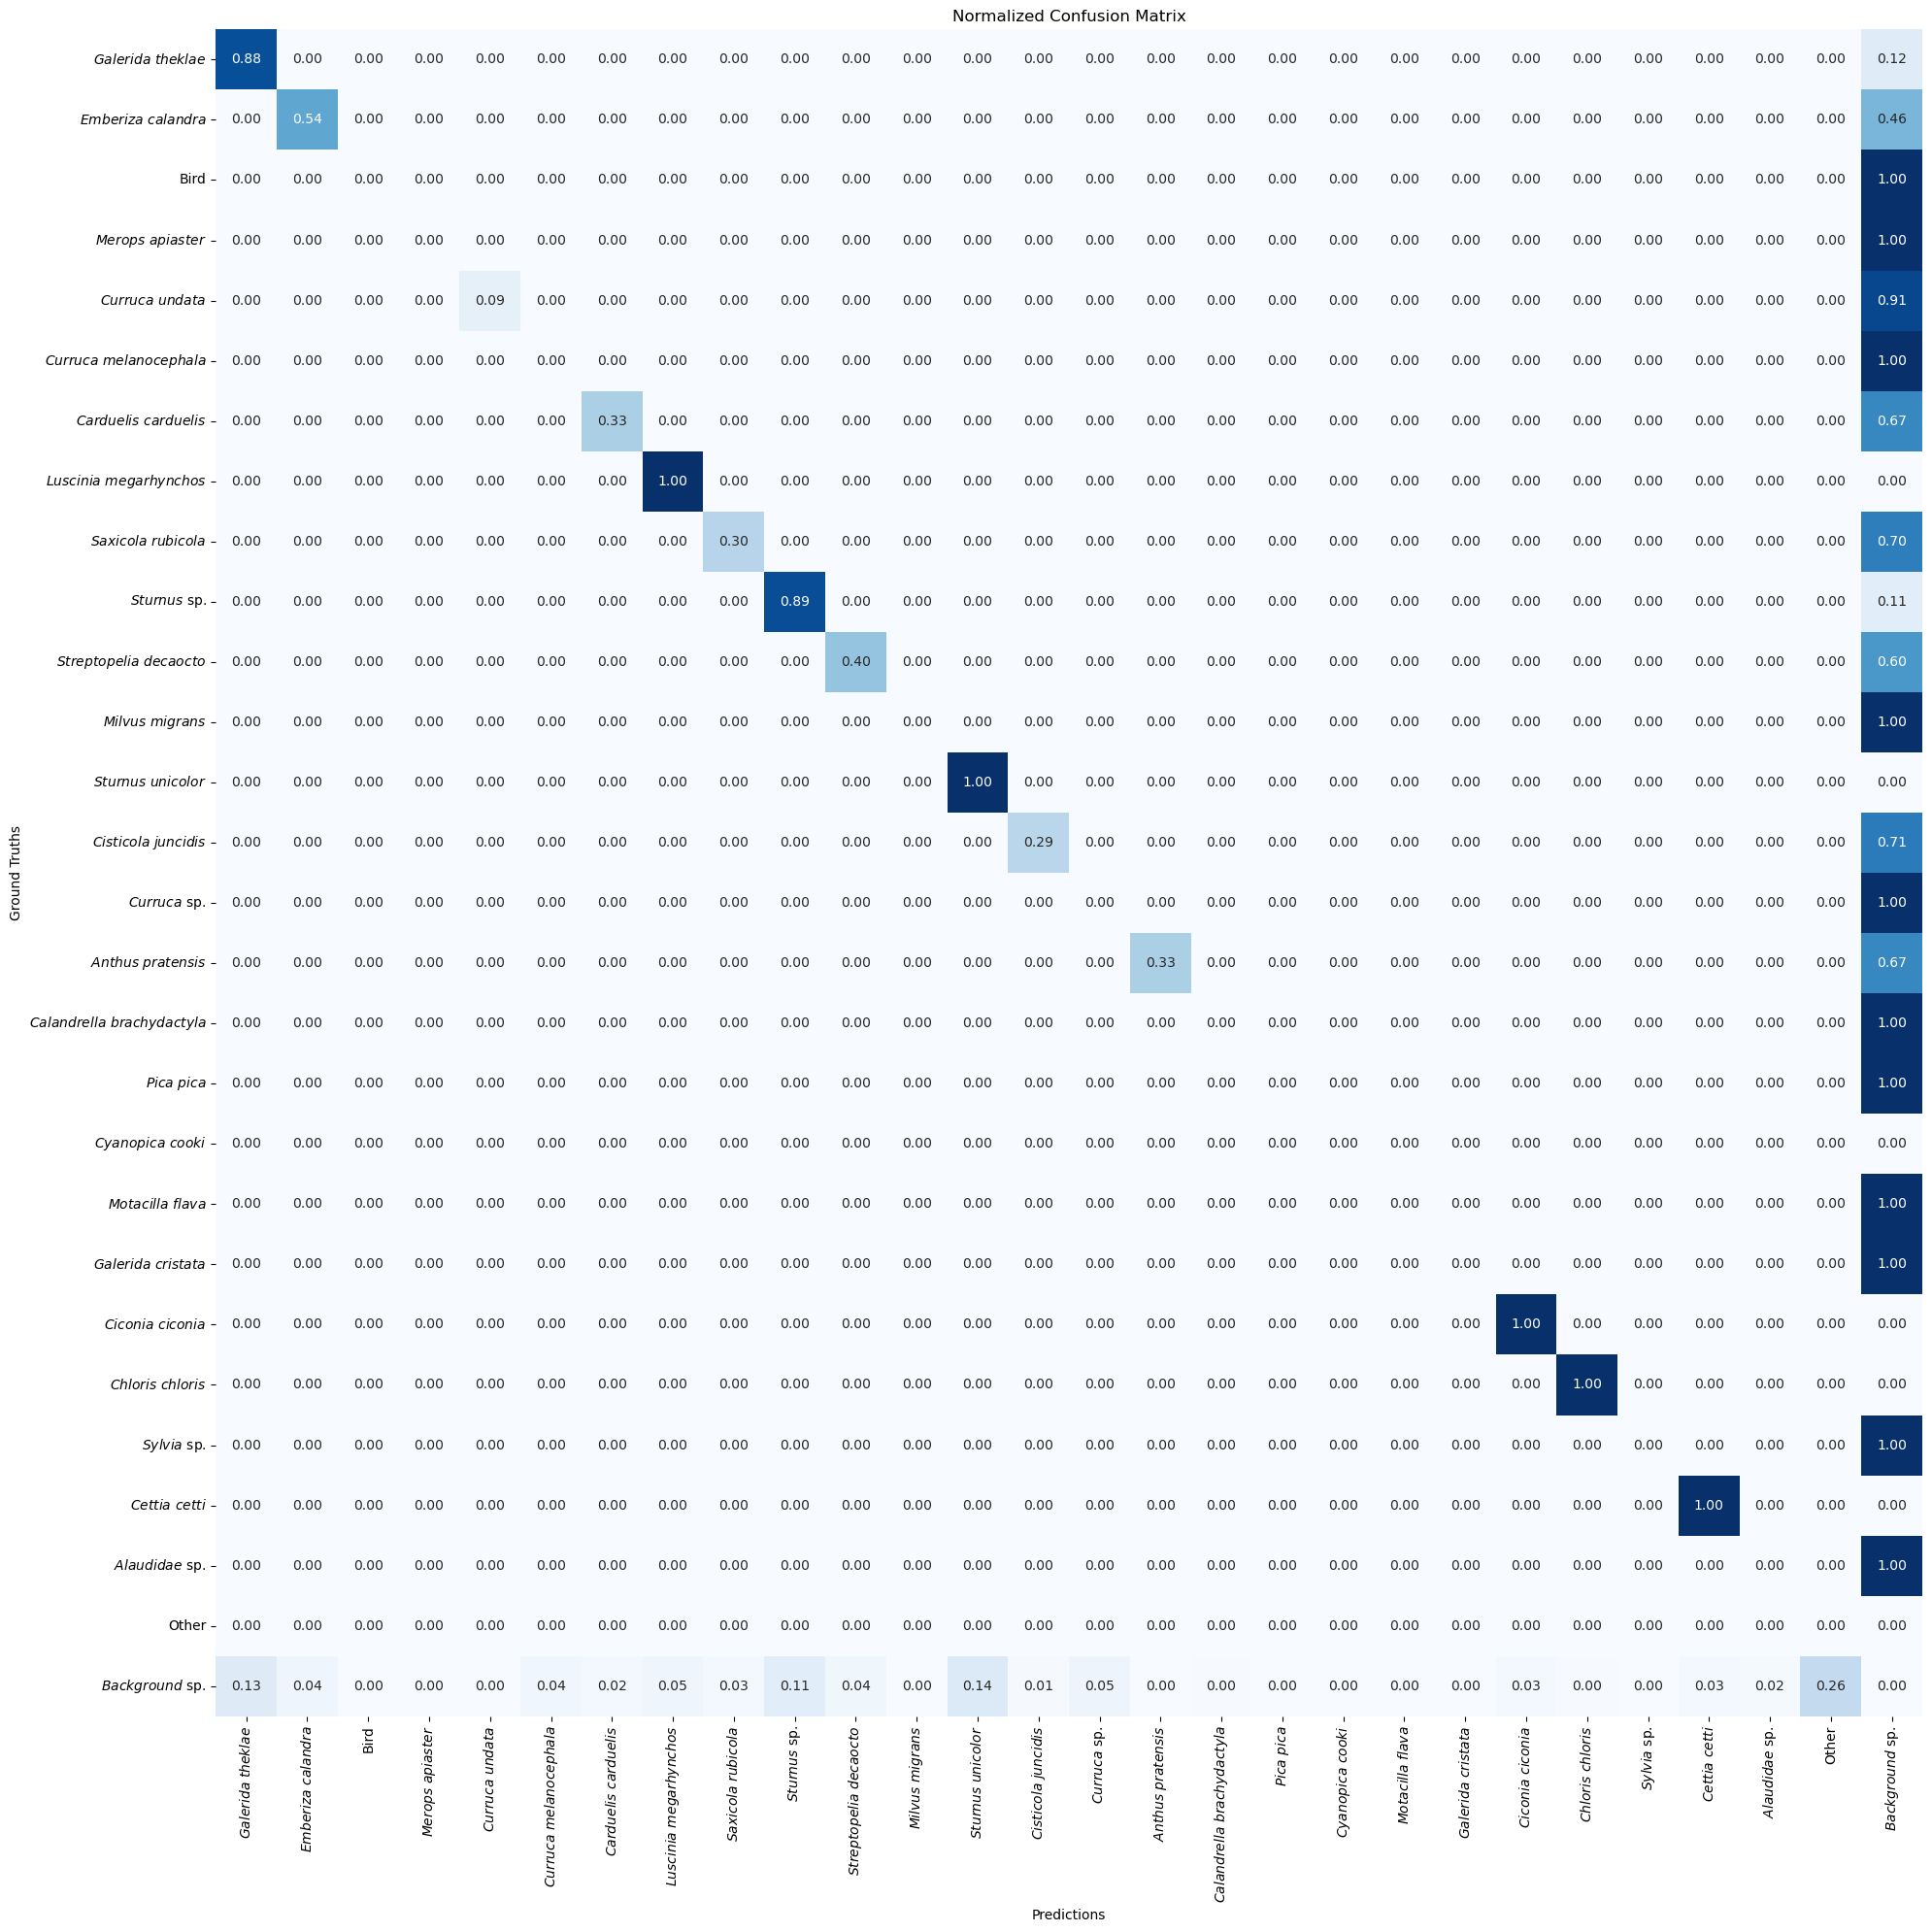

Detector + BirdNET
Número de Anotaciones:  521
Number of predictions:  290
True Positive:  67
False Positive:  223
False Negative:  118
True Negative:  0
Accuracy:  0.1642156862745098
Precision:  0.23103448275862068
Recall:  0.3621621621621622
F1 Score:  0.28210526315789475
Idx Pred/Ann:  0.5566218809980806


In [97]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define transformation function
def transform_species_name(specie):
    if specie == "Bird":
        return specie
    elif specie == "No audio":
        return "No Bird"
    elif specie == "Other":
        return "Other"
    elif specie == "Galerida Cristata":
        return "Galerida cristata"
    elif specie == "Linaria Cannabina":
        return "Linaria cannabina"
    elif len(specie.split()) == 2:
        return specie  # Handle italic in the plot
    else:
        return f"{specie} sp."  # Handle italic in the plot
    
# Load data
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"
gt_df = pd.read_csv(gt_csv)

iou_threshold = 0

number_of_annotations = 521 # with true positives

# Initialize counters
TP = 0
FP = 0
FN = 0
TN = 0

# Read all the predictions and group them, put all them in the same dataframe
pred_file_path = "../BirdNET/Predictions/predict_test_model12_conf015/"
predictions = pd.DataFrame()

# Read all CSV files in the folder
all_files = glob.iglob(os.path.join(pred_file_path, '**/*.csv'), recursive=True)
for file in all_files:
    # Read file and if there are predictions, group them
    predictions_df = pd.read_csv(file)
    if len(predictions_df) > 0:
        grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
        if grouped_predictions:
            # Add the basename of the file as a new column
            for group in grouped_predictions:
                group['basename'] = os.path.basename(file)
                # Add for each row to Start (s) the first value after a . in the basename
                group['Start (s)'] = group['Start (s)'] + float(group['basename'].split('.BirdNET')[0].split('_')[-3])
                group["End (s)"] = group["End (s)"] + float(group['basename'].split('.BirdNET')[0].split('_')[-3])
                group['basename'] = group['basename'].split(".BirdNET")[0].split("_")[0:3]
            predictions = pd.concat([predictions, pd.DataFrame(grouped_predictions)], ignore_index=True)

# Convert 'basename' from list to string
predictions['basename'] = predictions['basename'].apply(lambda x: '_'.join(x) if isinstance(x, list) else x)

predictions = predictions.loc[predictions.groupby(['basename','Start (s)', 'End (s)'])['Confidence'].idxmax()]

number_of_predictions = len(predictions)

# Inicializamos las métricas
TP, FP, FN, TN = 0, 0, 0, 0

# Define unique species and initialize confusion matrix
unique_species = gt_df['specie'].unique().tolist() + ['Other'] + ['Background']
conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

# Agrupamos predicciones por basename para que coincidan con los ficheros en gt_df
grouped_predictions = predictions.groupby('basename')

# Procesamos cada archivo de predicciones
for basename, predictions_df in grouped_predictions:
    # Obtenemos las anotaciones de gt_df para el basename actual
    gt_rows = gt_df[gt_df['basename'] == basename]

    # Procesamos cada anotación
    for _, gt_row in gt_rows.iterrows():
        # Comprobamos si hay detección
        detclass, pred = is_detection_classification_birdnet(gt_row, predictions_df, confidence_threshold=0, iou_threshold=iou_threshold)
        if detclass:
            predicted_species = pred['Scientific name']
            # Add to the confusion matrix
            conf_matrix.at[gt_row['specie'], predicted_species] += 1
            TP += 1
            # Remove the pred from the predictions dataframe so it is not used again by Start, End and Scientific name
            predictions_df = predictions_df.drop(pred.name)
        else:
            # Add to the confusion matrix
            conf_matrix.at[gt_row['specie'], 'Background'] += 1
            FN += 1
    
    # Procesamos las predicciones restantes
    for _, pred in predictions_df.iterrows():
        # If pred Scientific name not in unique species, set to 'Other'
        if pred['Scientific name'] not in unique_species:
            print(pred['Scientific name'])
            pred['Scientific name'] = 'Other'
        conf_matrix.at['Background', pred['Scientific name']] += 1
        FP += 1

# Normalize by row
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

# Apply transformation to confusion matrix labels
transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

# Create the plot
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')

# Customize labels for italic formatting
ax = plt.gca()
xticklabels = []
yticklabels = []
for label in ax.get_xticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    xticklabels.append(text)
ax.set_xticklabels(xticklabels, rotation=90)

for label in ax.get_yticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    yticklabels.append(text)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()

# save as png in the max resolution
plt.savefig('confusion_matrix_species.png', dpi=300, bbox_inches='tight')

plt.show()

print("Detector + BirdNET")
print("Número de Anotaciones: ", number_of_annotations)
print("Number of predictions: ", number_of_predictions)
print("True Positive: ", TP)
print("False Positive: ", FP)
print("False Negative: ", FN)
print("True Negative: ", TN)
    
print("Accuracy: ", TP/(TP + FP + FN))
print("Precision: ", TP/(TP + FP))
print("Recall: ", TP/(TP + FN))
print("F1 Score: ", 2 * TP / (2 * TP + FP + FN))

print("Idx Pred/Ann: ", number_of_predictions/number_of_annotations)

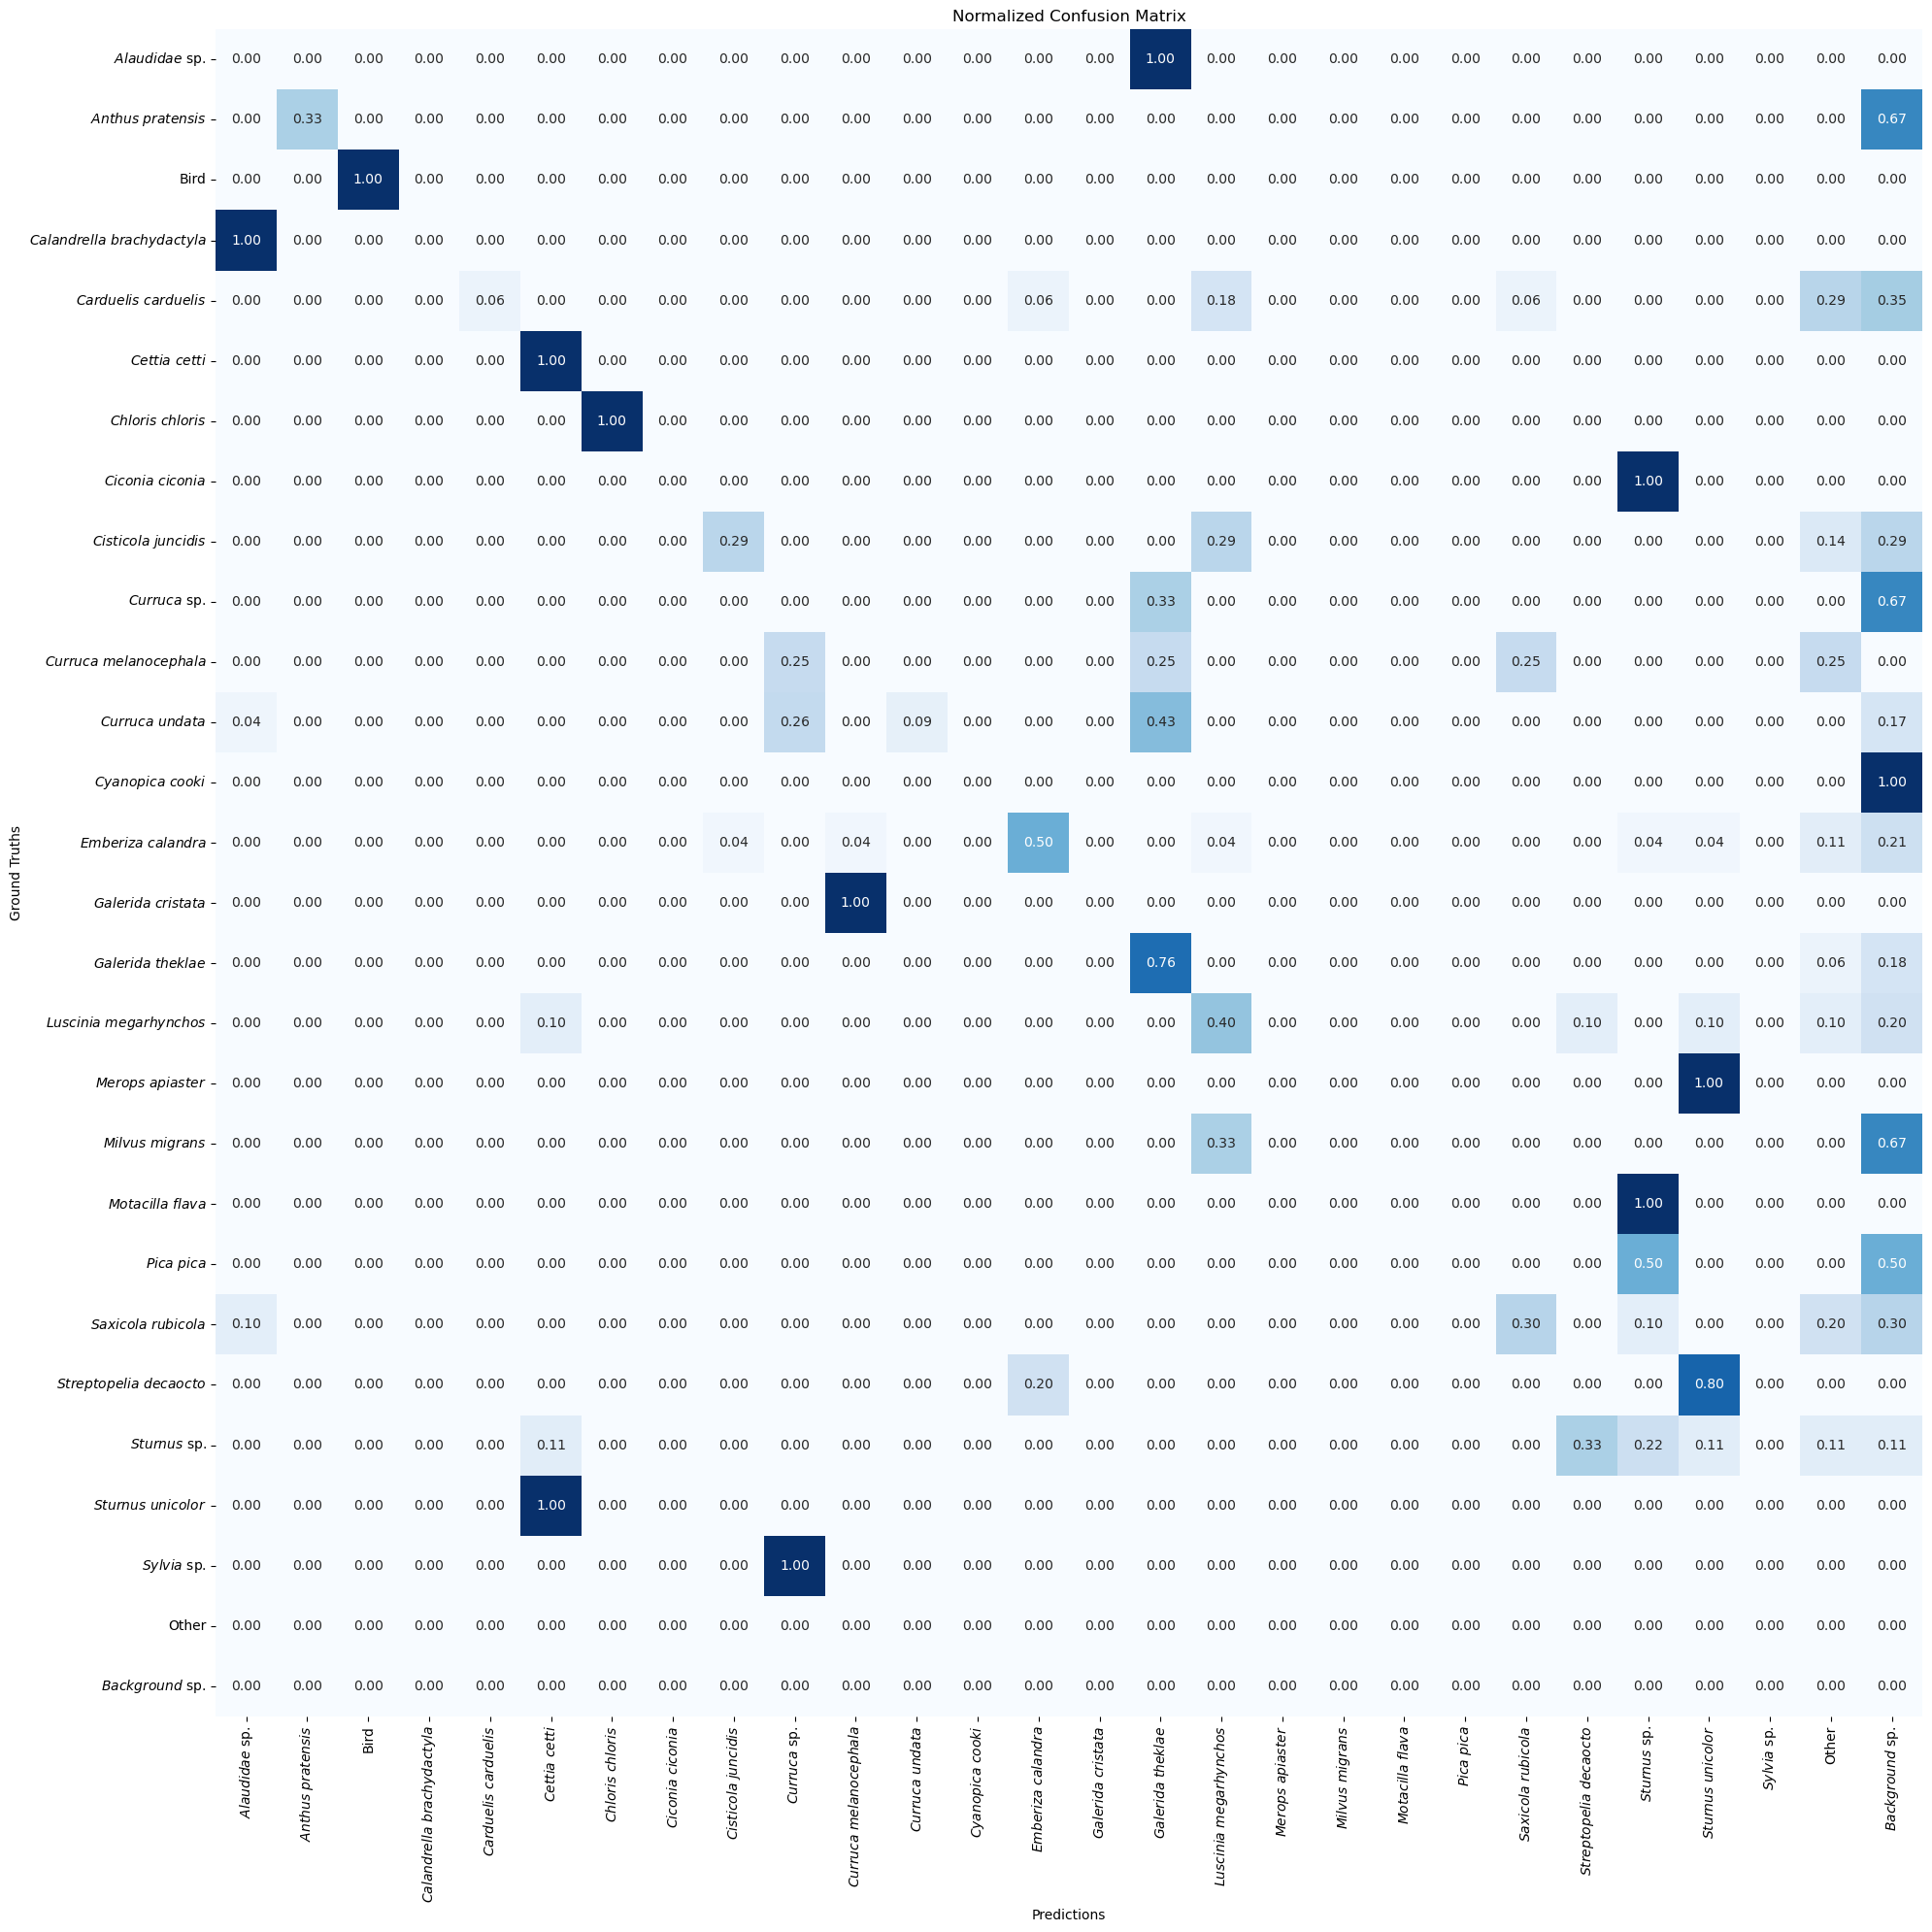

Bird Song Detector + BirdNET
Número de Anotaciones:  521
Number of predictions:  151
True Positive:  80
False Positive:  73
False Negative:  35
True Negative:  0
Accuracy:  0.425531914893617
Precision:  0.5228758169934641
Recall:  0.6956521739130435
F1 Score:  0.5970149253731343
Idx Pred/Ann:  0.28982725527831094


In [107]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define transformation function
def transform_species_name(specie):
    if specie == "Bird":
        return specie
    elif specie == "No audio":
        return "No Bird"
    elif specie == "Other":
        return "Other"
    elif specie == "Galerida Cristata":
        return "Galerida cristata"
    elif specie == "Linaria Cannabina":
        return "Linaria cannabina"
    elif len(specie.split()) == 2:
        return specie  # Handle italic in the plot
    else:
        return f"{specie} sp."  # Handle italic in the plot
    
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0
number_of_annotations = 0
number_of_predictions = 0

# Load data
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"
gt_df = pd.read_csv(gt_csv)

iou_threshold = 0

number_of_annotations = 521 # with true positives

# Initialize counters
TP = 0
FP = 0
FN = 0
TN = 0

# Define unique species and initialize confusion matrix
unique_species = gt_df['specie'].unique().tolist()

# Sort alphabetically unique species
unique_species.sort()

# Add ['Other'] + ['Background']
unique_species = unique_species + ['Other'] + ['Background']

conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

number_of_predictions = 0

# Extract basename of the file and add as basename column
gt_df['basename'] = gt_df['path'].apply(lambda x: os.path.basename(x).split('.')[0].split('/')[-1])

# # Read all the predictions and group them, put all them in the same dataframe
# pred_file_path = "../BirdNET/Predictions/predict_test_model12_conf015/"
# predictions = pd.DataFrame()

# # Read all CSV files in the folder
# all_files = glob.iglob(os.path.join(pred_file_path, '**/*.csv'), recursive=True)
# for file in all_files:
#     # Read file and if there are predictions, group them
#     predictions_df = pd.read_csv(file)
#     if len(predictions_df) > 0:
#         grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
#         if grouped_predictions:
#             # Add the basename of the file as a new column
#             for group in grouped_predictions:
#                 group['basename'] = os.path.basename(file)
#                 # Add for each row to Start (s) the first value after a . in the basename
#                 group['Start (s)'] = group['Start (s)'] + float(group['basename'].split('.BirdNET')[0].split('_')[-3])
#                 group["End (s)"] = group["End (s)"] + float(group['basename'].split('.BirdNET')[0].split('_')[-3])
#                 group['basename'] = group['basename'].split(".BirdNET")[0].split("_")[0:3]
#             predictions = pd.concat([predictions, pd.DataFrame(grouped_predictions)], ignore_index=True)

# # Convert 'basename' from list to string
# predictions['basename'] = predictions['basename'].apply(lambda x: '_'.join(x) if isinstance(x, list) else x)

# predictions = predictions.loc[predictions.groupby(['basename','Start (s)', 'End (s)'])['Confidence'].idxmax()]

# number_of_predictions = len(predictions)

# Inicializamos las métricas
TP, FP, FN, TN = 0, 0, 0, 0

# Process each prediction file
for _, gt_row in gt_df.iterrows():
    if len(gt_row['PRED_filename'].split('.')[-1]) == 1:
        gt_row['PRED_filename'] = gt_row['PRED_filename'] + '0'
    pred_file_path = f"../BirdNET/Predictions/predict_test_model12_conf015/{gt_row['PRED_filename']}.BirdNET.results.csv"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'Other'
                number_of_predictions += 1
            else:
                predicted_species = 'Other'
        else:
            predicted_species = 'Background'
    else:
        predicted_species = 'Background'
    
    true_species = gt_row['specie']
    if true_species == "Bird":
        predicted_species = true_species
    conf_matrix.at[true_species, predicted_species] += 1

# Calculate TP, FP... from conf_matrix
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        # If the species is Background and it is Background, it is TN
        if conf_matrix.index[i] == "Background" and conf_matrix.columns[j] == "Background":
            TN += conf_matrix.iloc[i, j]
        # If the species is Background and it is not Background, it is FP
        elif conf_matrix.index[i] == "Background" and conf_matrix.columns[j] != "Background":
            FP += conf_matrix.iloc[i, j]
        # If the species is not Background and it is Background, it is FN
        elif conf_matrix.index[i] != "Background" and conf_matrix.columns[j] == "Background":
            FN += conf_matrix.iloc[i, j]
        # If the species is the same as the prediction, it is TP
        elif conf_matrix.index[i] == conf_matrix.columns[j]:
            TP += conf_matrix.iloc[i, j]
        else:
            FP += conf_matrix.iloc[i, j]


# Normalize by row
conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

# Apply transformation to confusion matrix labels
transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

# Create the plot
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')

# Customize labels for italic formatting
ax = plt.gca()
xticklabels = []
yticklabels = []
for label in ax.get_xticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    xticklabels.append(text)
ax.set_xticklabels(xticklabels, rotation=90)

for label in ax.get_yticklabels():
    text = label.get_text()
    if text != "Bird" and text != "No Bird" and text != "Other":
        if " sp." in text:
            name_part = text.replace(' sp.', '')  # Species name
            text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
        else:
            text = text.replace(' ', r'\ ')
            text = rf"$\mathit{{{text}}}$"  # Italic species name
    yticklabels.append(text)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()

# save as png in the max resolution
plt.savefig('confusion_matrix_species.png', dpi=300, bbox_inches='tight')

plt.show()

print("Bird Song Detector + BirdNET")
print("Número de Anotaciones: ", number_of_annotations)
print("Number of predictions: ", number_of_predictions)
print("True Positive: ", TP)
print("False Positive: ", FP)
print("False Negative: ", FN)
print("True Negative: ", TN)
    
print("Accuracy: ", TP/(TP + FP + FN))
print("Precision: ", TP/(TP + FP))
print("Recall: ", TP/(TP + FN))
print("F1 Score: ", 2 * TP / (2 * TP + FP + FN))

print("Idx Pred/Ann: ", number_of_predictions/number_of_annotations)

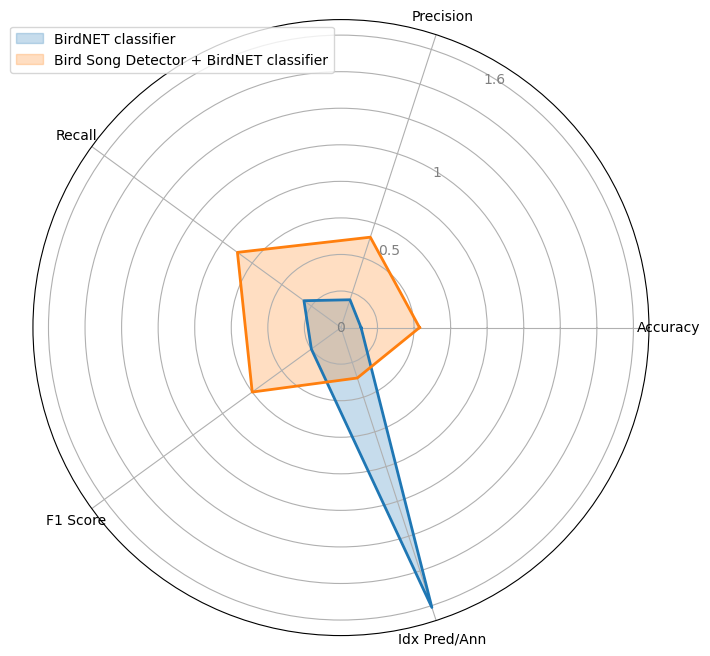

In [15]:
import numpy as np
import matplotlib.pyplot as plt

'''
BirdNET
Número de Anotaciones:  521
Number of predictions: 836
True Positive:  136
False Positive:  700
False Negative:  406
True Negative:  0
Accuracy:  0.10950080515297907
Precision:  0.16267942583732056
Recall:  0.25092250922509224
F1 Score:  0.19738751814223512
Idx Pred/Ann:  1.6046065259117082

Bird Song Detector + BirdNET
Número de Anotaciones:  521
Number of predictions:  151
True Positive:  80
False Positive:  73
False Negative:  35
True Negative:  0
Accuracy:  0.425531914893617
Precision:  0.5228758169934641
Recall:  0.6956521739130435
F1 Score:  0.5970149253731343
Idx Pred/Ann:  0.28982725527831094
'''

# Datos de las métricas para los dos modelos
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann']
model_1 = [0.11, 0.16, 0.25, 0.20, 1.61]
model_2 = [0.43, 0.52, 0.70, 0.60, 0.29]

# Número de variables
num_vars = len(metrics)

# Ángulos para la gráfica de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Inicializar la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar la gráfica de radar
ax.fill(angles, model_1, color='C0', alpha=0.25, label='BirdNET classifier')
ax.fill(angles, model_2, color='C1', alpha=0.25, label='Bird Song Detector + BirdNET classifier')

# Dibujar las líneas de los modelos
ax.plot(angles, model_1, color='C0', linewidth=2, linestyle='solid')
ax.plot(angles, model_2, color='C1', linewidth=2, linestyle='solid')

# Añadir las etiquetas de las métricas
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Añadir la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1))

# Add min, middle and max value to the radar chart
ax.text(45, 0, '0', color='grey', ha='center', va='center')
ax.text(45, 0.5, '0.5', color='grey', ha='center', va='center')
ax.text(45, 1, '1', color='grey', ha='center', va='center')
ax.text(45, 1.6, '1.6', color='grey', ha='center', va='center')

# Título de la gráfica
# plt.title('Comparison of Model Metrics')

# Mostrar la gráfica
plt.show()

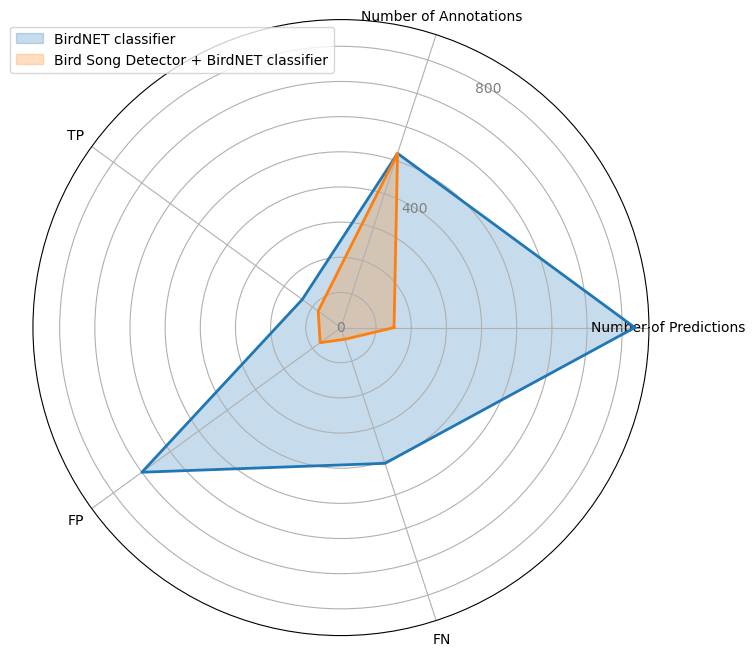

In [14]:
import numpy as np
import matplotlib.pyplot as plt

'''
BirdNET
Número de Anotaciones:  521
Number of predictions: 836
True Positive:  136
False Positive:  700
False Negative:  406
True Negative:  0
Accuracy:  0.10950080515297907
Precision:  0.16267942583732056
Recall:  0.25092250922509224
F1 Score:  0.19738751814223512
Idx Pred/Ann:  1.6046065259117082

Bird Song Detector + BirdNET
Número de Anotaciones:  521
Number of predictions:  151
True Positive:  80
False Positive:  73
False Negative:  35
True Negative:  0
Accuracy:  0.425531914893617
Precision:  0.5228758169934641
Recall:  0.6956521739130435
F1 Score:  0.5970149253731343
Idx Pred/Ann:  0.28982725527831094
'''

# Datos de las métricas para los dos modelos
metrics = ['Number of Predictions', 'Number of Annotations', 'TP', 'FP', 'FN']
model_1 = [836,521, 136, 700, 406]
model_2 = [151, 521, 80, 73, 35]

# Número de variables
num_vars = len(metrics)

# Ángulos para la gráfica de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Inicializar la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar la gráfica de radar
ax.fill(angles, model_1, color='C0', alpha=0.25, label='BirdNET classifier')
ax.fill(angles, model_2, color='C1', alpha=0.25, label='Bird Song Detector + BirdNET classifier')

# Dibujar las líneas de los modelos
ax.plot(angles, model_1, color='C0', linewidth=2, linestyle='solid')
ax.plot(angles, model_2, color='C1', linewidth=2, linestyle='solid')

# Añadir las etiquetas de las métricas
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Añadir la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1))

# Add min, middle and max value to the radar chart
ax.text(45, 0, '0', color='grey', ha='center', va='center')
ax.text(45, 400, '400', color='grey', ha='center', va='center')
ax.text(45, 800, '800', color='grey', ha='center', va='center')

# Título de la gráfica
# plt.title('Comparison of Model Metrics')

# Mostrar la gráfica
plt.show()